# Microbiota Compositional Analysis
## Salmo salar mucosal tissue microbiota across functional feed treatments

#### Load libraries

In [1]:
set.seed(123)
suppressPackageStartupMessages(library(phyloseq)); packageVersion("phyloseq")
suppressPackageStartupMessages(library(ggplot2)); packageVersion("ggplot2")
suppressPackageStartupMessages(library(dplyr)); packageVersion("dplyr")
suppressPackageStartupMessages(library(vegan)); packageVersion('vegan')
suppressPackageStartupMessages(library(multcomp)); packageVersion('multcomp')
suppressPackageStartupMessages(library(car)); packageVersion('car')
suppressPackageStartupMessages(library(tidyverse)); packageVersion('tidyverse')
suppressPackageStartupMessages(library(viridis))

[1] ‘1.32.0’

Warning message:
“package ‘ggplot2’ was built under R version 4.0.2”


[1] ‘3.3.5’

Warning message:
“package ‘dplyr’ was built under R version 4.0.2”


[1] ‘1.0.7’

Warning message:
“package ‘vegan’ was built under R version 4.0.2”
Warning message:
“package ‘lattice’ was built under R version 4.0.2”


[1] ‘2.5.7’

Warning message:
“package ‘multcomp’ was built under R version 4.0.2”
Warning message:
“package ‘mvtnorm’ was built under R version 4.0.2”
Warning message:
“package ‘survival’ was built under R version 4.0.2”
Warning message:
“package ‘MASS’ was built under R version 4.0.2”


[1] ‘1.4.17’

Warning message:
“package ‘car’ was built under R version 4.0.2”


[1] ‘3.0.12’

Warning message:
“package ‘tidyverse’ was built under R version 4.0.2”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘readr’ was built under R version 4.0.2”
Warning message:
“package ‘stringr’ was built under R version 4.0.2”
Warning message:
“package ‘forcats’ was built under R version 4.0.2”


[1] ‘1.3.1’

Warning message:
“package ‘viridis’ was built under R version 4.0.2”


#### Read in metadata and phyloseq object created in DADA2 notebook

In [2]:
metaDF <- (read.csv('metaDF.csv'))
row.names(metaDF) <- metaDF$SampleID
metaDF <- metaDF[-1]
head(metaDF)

,SampleID,Tank,Fish,Tissue,Diet
,<chr>,<chr>,<chr>,<chr>,<chr>
Diet_Blue1,Diet_Blue1,Diet,Blue1,Diet,Control
Diet_Blue2,Diet_Blue2,Diet,Blue2,Diet,Control
Diet_Green1,Diet_Green1,Diet,Green1,Diet,Coco+MOS
Diet_Green2,Diet_Green2,Diet,Green2,Diet,Coco+MOS
Diet_Orange1,Diet_Orange1,Diet,Orange1,Diet,MOS
Diet_Orange2,Diet_Orange2,Diet,Orange2,Diet,MOS


In [3]:
ps <- readRDS("NCWMAC_ps_wTree.RDS")
ps
sample_data(ps) <- metaDF
ps
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9265 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 4 sample variables ]
tax_table()   Taxonomy Table:    [ 9265 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9265 tips and 9263 internal nodes ]
refseq()      DNAStringSet:      [ 9265 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9265 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 9265 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9265 tips and 9263 internal nodes ]
refseq()      DNAStringSet:      [ 9265 reference sequences ]

#### Write fasta file to run pairwise ASV similarity search with BLASTn upstream of LULU

In [4]:
Biostrings::writeXStringSet(refseq(ps), 'NCWMAC_refSeqs.fasta')

#### Read in results from BLASTn ASV similarity search

In [5]:
matchList <- read.table('ASVmatch_list.txt', sep='\t')
matchList$V3 <- as.numeric(matchList$V3)
head(matchList)

,V1,V2,V3
,<chr>,<chr>,<dbl>
1,ASV1,ASV1,100.000
2,ASV1,ASV6478,99.766
3,ASV1,ASV6193,99.766
4,ASV1,ASV6050,99.766
5,ASV1,ASV6005,99.766
6,ASV1,ASV5978,99.766


#### Run LULU ASV post-clustering

In [6]:
library('lulu')

In [7]:
otuTab <- data.frame(t(otu_table(ps)))

In [8]:
curated_results <- readRDS('LULUcuratedresults.RDS')

In [9]:
ps <- prune_taxa(curated_results$curated_otus, ps)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3240 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 3240 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3240 tips and 3239 internal nodes ]
refseq()      DNAStringSet:      [ 3240 reference sequences ]

#### Remove contamination (mitochondria and choloroplast)

In [10]:
ps <- subset_taxa(ps, !is.na(Phylum) 
                  & !Family %in% c('Mitochondria')
                  & !Order %in% c('Chloroplast'))
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3114 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 3114 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3114 tips and 3113 internal nodes ]
refseq()      DNAStringSet:      [ 3114 reference sequences ]

#### Analyze Positive Controls

In [11]:
POS <- subset_samples(ps, Tissue == 'Pos')
POS <- prune_taxa(taxa_sums(POS) > 0, POS)
POS <- subset_taxa(POS, !is.na(Genus))
POS <- prune_taxa(taxa_sums(POS) > 0, POS)       
#plot_bar(POS, fill='Genus')
POSr <- transform_sample_counts(POS, function(x) x / sum(x))
POSrGP <- plot_bar(POSr, fill='Genus'
                  ) 

In [12]:
meanPOSr <- psmelt(POSr) %>% dplyr::select(Abundance, Tank, Genus) %>% group_by(Tank,Genus) %>% summarise(Abundance = sum(Abundance)*100) #%>% mutate(Group = paste0(Tank,"_Positive")) #%>% filter(Genus != 'NA')
TruePosComp <- tibble('Genus' = c('Pseudomonas',
                                      'Escherichia/Shigella',
                                      'Salmonella', 
                                      'Lactobacillus', 
                                      'Enterococcus', 
                                      'Staphylococcus',
                                      'Listeria',
                                      'Bacillus'),
                         'Abundance' = c(4.2,
                                        10.1,
                                        10.4,
                                        18.4,
                                        9.9,
                                        15.5,
                                        14.1,
                                        17.4),
                      'Tank' = rep('Theoretical', 8))
POSres <- as.data.frame(rbind(TruePosComp, meanPOSr))
POSres <- POSres %>% mutate(Group=Tank)
POSres$Group <- POSres$Group %>% dplyr::recode(Gill='Pos_1', Gut='Pos_2', Skin='Pos_3')
POSres$Group <- factor(POSres$Group, levels = c('Pos_1', 'Pos_2', 'Pos_3', 'Theoretical'))

`summarise()` has grouped output by 'Tank'. You can override using the `.groups` argument.



In [13]:
POSplot <- ggplot(POSres,aes(x=Group, y=Abundance, fill = Group)) + geom_bar(stat="identity") + facet_wrap('Genus') + ylab('Relative Abundance %') + theme_bw() + theme(axis.title.x = element_blank(),
                                                                                                                                                           axis.text.x = element_blank(),
                                                                                                                                                           axis.ticks.x = element_blank()
                                                                                                                                                           ) + scale_y_continuous(limits=c(0,100), expand=c(0,.8)) 
ggsave('Figures/Manuscript/PosConPlot.png', width=7, height=7, dpi=320, scale=1)

#### Analyze Negative Controls

In [14]:
NTCs <- subset_samples(ps, Tissue == 'NTC')
NTCs <- prune_taxa(taxa_sums(NTCs) > 0, NTCs)
NTC_Tissues = merge_samples(NTCs, "Tank")
#NTCs.fam10 <- microbiome::aggregate_top_taxa(NTCs, "Family", top = 10)
NTCr <- transform_sample_counts(NTC_Tissues, function(x) x / sum(x))
NTCr.fam10 <- microbiome::aggregate_top_taxa(NTCr, "Genus", top = 20)

Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”


In [15]:
mean(sample_sums(NTCs))
sd(sample_sums(NTCs))

[1] 2845

[1] 1452.828

In [16]:
#plot_bar(NTCs, fill='Family')
NTCplot <- plot_bar(NTCr.fam10, fill='Genus') + theme_bw() + theme(axis.text.x = element_blank(),
                            axis.ticks = element_blank()
                           ) + scale_y_continuous( limits = c(0,1.01),expand = c(0, 0)) + xlab('') 
ggsave('Figures/Manuscript/NegConPlot.png', width=7, height=7, dpi=320, scale=1)

Saving 7 x 7 in image



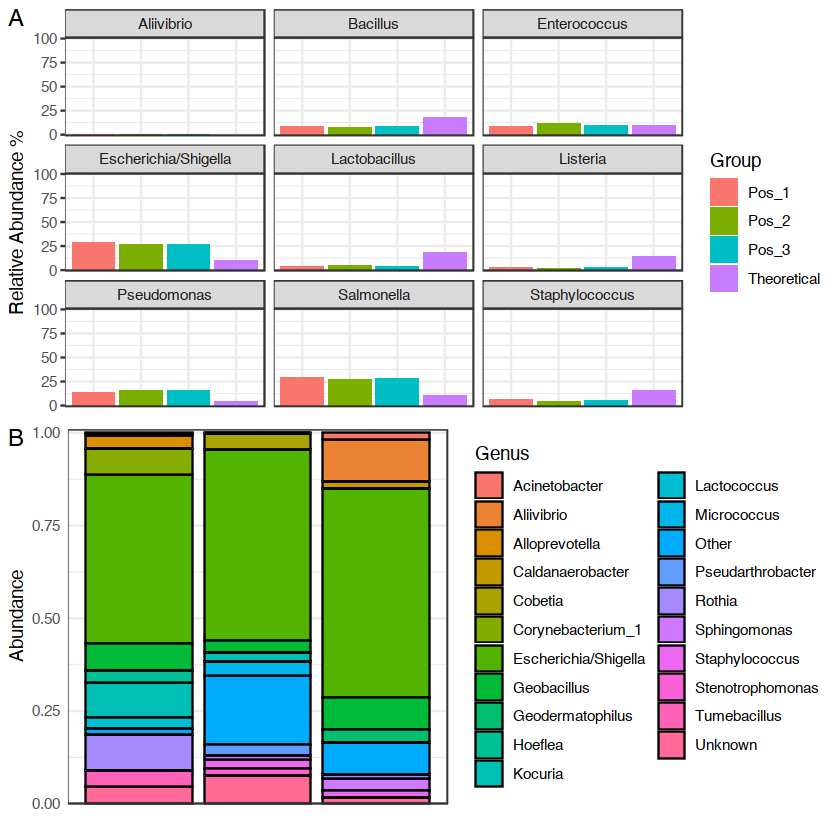

In [17]:
ggpubr::ggarrange(POSplot, NTCplot, ncol=1, labels="AUTO")
ggsave('Figures/Manuscript/PosNegControlPlots.png')

# Remove controls

In [18]:
psNCBISamps <- prune_samples(sample_data(ps)$Tissue %in% c('Gut', 'Gill', 'Skin','Diet', 'Water'), ps)
psNCBISamps
saveRDS(psNCBISamps, 'psNCBISamps.RDS')

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3114 taxa and 226 samples ]
sample_data() Sample Data:       [ 226 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 3114 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3114 tips and 3113 internal nodes ]
refseq()      DNAStringSet:      [ 3114 reference sequences ]

In [19]:
table(sample_data(ps)$Tissue)
table(sample_data(psNCBISamps)$Tissue)


 Diet  Gill   Gut   NTC   Pos  Skin Water 
    8    72    71    11     3    72     3 


 Diet  Gill   Gut  Skin Water 
    8    72    71    72     3 

### Create sub datasets

In [20]:
psFish <- prune_samples(sample_data(ps)$Tissue %in% c('Gut', 'Gill', 'Skin'), ps)
psFish
psControls <- prune_samples(sample_data(ps)$Diet %in% c('Positive', 'Negative'), ps)
psControls
psDietWater <- prune_samples(sample_data(ps)$Tank %in% c('Diet', 'Water'), ps)
psDietWater

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3114 taxa and 215 samples ]
sample_data() Sample Data:       [ 215 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 3114 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3114 tips and 3113 internal nodes ]
refseq()      DNAStringSet:      [ 3114 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3114 taxa and 14 samples ]
sample_data() Sample Data:       [ 14 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 3114 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3114 tips and 3113 internal nodes ]
refseq()      DNAStringSet:      [ 3114 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3114 taxa and 11 samples ]
sample_data() Sample Data:       [ 11 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 3114 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3114 tips and 3113 internal nodes ]
refseq()      DNAStringSet:      [ 3114 reference sequences ]

In [21]:
psDiet <- prune_samples(sample_data(ps)$Tank == 'Diet', ps)
psDiet <- filter_taxa(psDiet, function(x) sum(x) > 2, TRUE)
psDiet
                      
psWater <- prune_samples(sample_data(ps)$Tank == 'Water', ps)
psWater <- filter_taxa(psWater, function(x) sum(x) > 2, TRUE)
psWater                      

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 265 taxa and 8 samples ]
sample_data() Sample Data:       [ 8 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 265 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 265 tips and 264 internal nodes ]
refseq()      DNAStringSet:      [ 265 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 637 taxa and 3 samples ]
sample_data() Sample Data:       [ 3 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 637 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 637 tips and 636 internal nodes ]
refseq()      DNAStringSet:      [ 637 reference sequences ]

In [22]:
psFish <- filter_taxa(psFish, function(x) sum(x) >= 1, TRUE)
psFish
psControls <- filter_taxa(psControls, function(x) sum(x) >= 1, TRUE)
psControls
psDietWater <- filter_taxa(psDietWater, function(x) sum(x) >= 1, TRUE)
psDietWater

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2972 taxa and 215 samples ]
sample_data() Sample Data:       [ 215 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 2972 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2972 tips and 2971 internal nodes ]
refseq()      DNAStringSet:      [ 2972 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 80 taxa and 14 samples ]
sample_data() Sample Data:       [ 14 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 80 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 80 tips and 79 internal nodes ]
refseq()      DNAStringSet:      [ 80 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 936 taxa and 11 samples ]
sample_data() Sample Data:       [ 11 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 936 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 936 tips and 935 internal nodes ]
refseq()      DNAStringSet:      [ 936 reference sequences ]

In [23]:
levels(sample_data(psFish)$Diet)
sample_data(psFish)$Diet <- factor(sample_data(psFish)$Diet, levels=c("Control","MOS","CoconutOil", "Coco+MOS"))
levels(sample_data(psFish)$Diet)

NULL

[1] "Control"    "MOS"        "CoconutOil" "Coco+MOS"

#### Remove bad samples (<= 24182 reads) and spurious ASVs (< 0.00001% abundance)

In [24]:
mean(sample_sums(psFish))
sd(sample_sums(psFish))
range(sample_sums(psFish))
tail(sort(sample_sums(psFish), decreasing = TRUE), 10)

[1] 48746.44

[1] 24316.46

[1]     20 157812

T7_F1_Skin T20_F3_Skin  T9_F1_Skin  T6_F2_Skin  T22_F2_Gut   T9_F3_Gut 
      25333       25072       24794       24182         181         134 
T24_F2_Gill  T24_F3_Gut  T7_F3_Gill  T8_F3_Gill 
         71          49          32          20

In [25]:
psFish1 <- prune_samples(sample_sums(psFish)>=24180, psFish)
psFish1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2972 taxa and 209 samples ]
sample_data() Sample Data:       [ 209 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 2972 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2972 tips and 2971 internal nodes ]
refseq()      DNAStringSet:      [ 2972 reference sequences ]

In [26]:
table(sample_data(psFish1)$Diet)
table(sample_data(psFish1)$Tissue)


   Control        MOS CoconutOil   Coco+MOS 
        53         54         54         48 


Gill  Gut Skin 
  69   68   72 

#### Dropped 4 gut (1 gut sample already removed) and 3 gill samples overall

In [27]:
mean(sample_sums(psFish1))
sd(sample_sums(psFish1))
range(sample_sums(psFish1))
tail(sort(sample_sums(psFish1), decreasing = TRUE), 5)

[1] 50143.53

[1] 23196.31

[1]  24182 157812

T8_F3_Skin  T7_F1_Skin T20_F3_Skin  T9_F1_Skin  T6_F2_Skin 
      25765       25333       25072       24794       24182

In [28]:
psFish1r  <- transform_sample_counts(psFish1, function(x) x / sum(x))
psFish1rf <- filter_taxa(psFish1r, function(x) mean(x) > 1e-5, TRUE)
psFish1rf # relative abundance
saveRDS(psFish1rf, 'psFish1rf.RDS')
                         
psFish1f <- prune_taxa(taxa_names(psFish1rf), psFish1)
psFish1f # absolute count
saveRDS(psFish1f, 'psFish1f.RDS')                    

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2378 taxa and 209 samples ]
sample_data() Sample Data:       [ 209 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 2378 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2378 tips and 2377 internal nodes ]
refseq()      DNAStringSet:      [ 2378 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2378 taxa and 209 samples ]
sample_data() Sample Data:       [ 209 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 2378 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2378 tips and 2377 internal nodes ]
refseq()      DNAStringSet:      [ 2378 reference sequences ]

#### Write FASTA and otu table for PICRUST2

In [29]:
Biostrings::writeXStringSet(refseq(psFish1f), 'PICRUST/Fish1f_refSeqs.fasta')
write.table(t(otu_table(psFish1f)), sep='\t', 'PICRUST/Fish1f_otutab.txt', quote = FALSE, col.names =NA)

### Beta diversity

#### Run unifrac and analyze beta diversity

In [30]:
set.seed(123)
allFish.wUn.Dist <- distance(psFish1rf, method = "wunifrac")
saveRDS(allFish.wUn.Dist, 'fish_weightedUniFrac_Dist.RDS')
allFish.uwUn.Dist <- distance(psFish1rf, method = "unifrac")
saveRDS(allFish.uwUn.Dist, 'fish_unweightedUniFrac_Dist.RDS')

In [31]:
allFish.wUn.ord <- ordinate(psFish1rf, method = "PCoA", allFish.wUn.Dist)
saveRDS(allFish.wUn.ord, 'fish_weightedUniFrac_PCoAord.RDS')
allFish.uwUn.ord <- ordinate(psFish1rf, method = "PCoA", allFish.uwUn.Dist)
saveRDS(allFish.uwUn.ord, 'fish_unweightedUniFrac_PCoAord.RDS')

#### Test multivariate dispersion of full dataset - tissue does not have homogeneity of variance

In [32]:
metaDict <- as(sample_data(psFish1rf), "data.frame")
tissueGroups <- metaDict[["Tissue"]]
DietGroups <- metaDict[["Diet"]]

In [33]:
set.seed(123)
modTuwUni <- betadisper(allFish.uwUn.Dist, tissueGroups)
anova(modTuwUni)
modDuwUni <- betadisper(allFish.uwUn.Dist, DietGroups)
anova(modDuwUni)

modTwUni <- betadisper(allFish.wUn.Dist, tissueGroups)
anova(modTwUni)
modTwUni <- betadisper(allFish.wUn.Dist, DietGroups)
anova(modTwUni)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,2,0.1159793,0.057989643,26.57982,5.381278e-11
Residuals,206,0.4494337,0.002181717,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.00515122,0.001717073,0.3907353,0.7597969
Residuals,205,0.90086578,0.004394467,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,2,2.713420,1.356710049,167.0357,7.688827e-44
Residuals,206,1.673189,0.008122278,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.05271773,0.01757258,0.4612863,0.7096268
Residuals,205,7.80941967,0.03809473,NA,NA


#### Run global and pairwise PERMANOVA on unweighted UniFrac - test for tissue and diet effects while controlling for nested effects of tank

In [34]:
set.seed(123)
perm <- how(nperm = 999)
adonis2(allFish.uwUn.Dist ~ Tissue * Diet + Diet/Tank, data=metaDict, permutations = perm) 

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Tissue,2,14.4753139,0.23021787,31.525304,0.001
Diet,3,0.8667303,0.01378463,1.258415,0.095
Tissue:Diet,6,1.6261992,0.02586335,1.180548,0.097
Diet:Tank,20,5.2722470,0.08385072,1.148225,0.036
Residual,177,40.6360965,0.64628344,NA,NA
Total,208,62.8765869,1.00000000,NA,NA


In [36]:
set.seed(123)
library(RVAideMemoire)
pairwise.perm.manova(allFish.uwUn.Dist, metaDict$Tissue)
pairwise.perm.manova(allFish.uwUn.Dist, metaDict$Diet)

Warning message:
“package ‘RVAideMemoire’ was built under R version 4.0.2”
*** Package RVAideMemoire v 0.9-80 ***




	Pairwise comparisons using permutation MANOVAs on a distance matrix 

data:  allFish.uwUn.Dist by metaDict$Tissue
999 permutations 

     Gill  Gut  
Gut  0.001 -    
Skin 0.001 0.001

P value adjustment method: fdr 


	Pairwise comparisons using permutation MANOVAs on a distance matrix 

data:  allFish.uwUn.Dist by metaDict$Diet
999 permutations 

           Control MOS  CoconutOil
MOS        0.70    -    -         
CoconutOil 0.70    0.83 -         
Coco+MOS   0.70    0.70 0.70      

P value adjustment method: fdr 

#### Run global and pairwise PERMANOVA on weighted UniFrac

In [37]:
set.seed(123)
perm <- how(nperm = 999)
adonis2(allFish.wUn.Dist ~ Tissue * Diet + Diet/Tank, data=metaDict, permutations = perm)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Tissue,2,11.629872,0.31224392,47.710372,0.001
Diet,3,0.403425,0.01083133,1.103340,0.279
Tissue:Diet,6,0.790006,0.02121043,1.080306,0.304
Diet:Tank,20,2.850065,0.07651979,1.169210,0.113
Residual,177,21.572745,0.57919453,NA,NA
Total,208,37.246113,1.00000000,NA,NA


In [38]:
pairwise.perm.manova(allFish.wUn.Dist, metaDict$Tissue)
pairwise.perm.manova(allFish.wUn.Dist, metaDict$Diet)


	Pairwise comparisons using permutation MANOVAs on a distance matrix 

data:  allFish.wUn.Dist by metaDict$Tissue
999 permutations 

     Gill  Gut  
Gut  0.001 -    
Skin 0.001 0.001

P value adjustment method: fdr 


	Pairwise comparisons using permutation MANOVAs on a distance matrix 

data:  allFish.wUn.Dist by metaDict$Diet
999 permutations 

           Control MOS  CoconutOil
MOS        0.74    -    -         
CoconutOil 0.74    0.74 -         
Coco+MOS   0.74    0.74 0.74      

P value adjustment method: fdr 

### Generate tissue specific datasets for beta diversity

In [39]:
psGut <- prune_samples(sample_data(psFish1f)$Tissue %in% c('Gut'), psFish1f)
psGut
psGill <- prune_samples(sample_data(psFish1f)$Tissue %in% c('Gill'), psFish1f)
psGill
psSkin <- prune_samples(sample_data(psFish1f)$Tissue %in% c('Skin'), psFish1f)
psSkin

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2378 taxa and 68 samples ]
sample_data() Sample Data:       [ 68 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 2378 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2378 tips and 2377 internal nodes ]
refseq()      DNAStringSet:      [ 2378 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2378 taxa and 69 samples ]
sample_data() Sample Data:       [ 69 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 2378 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2378 tips and 2377 internal nodes ]
refseq()      DNAStringSet:      [ 2378 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2378 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 2378 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2378 tips and 2377 internal nodes ]
refseq()      DNAStringSet:      [ 2378 reference sequences ]

In [40]:
psGut <- filter_taxa(psGut, function(x) sum(x) > 1, TRUE)
psGut
psGill <- filter_taxa(psGill, function(x) sum(x) > 1, TRUE)
psGill
psSkin <- filter_taxa(psSkin, function(x) sum(x) > 1, TRUE)
psSkin

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 448 taxa and 68 samples ]
sample_data() Sample Data:       [ 68 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 448 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 448 tips and 447 internal nodes ]
refseq()      DNAStringSet:      [ 448 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1818 taxa and 69 samples ]
sample_data() Sample Data:       [ 69 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 1818 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1818 tips and 1817 internal nodes ]
refseq()      DNAStringSet:      [ 1818 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1604 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 1604 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1604 tips and 1603 internal nodes ]
refseq()      DNAStringSet:      [ 1604 reference sequences ]

#### Test beta dispersion diet within gut tissue

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.08553969,0.02851323,1.841545,0.1485328
Residuals,64,0.99093256,0.01548332,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.0008741684,0.0002913895,0.1416456,0.9346485
Residuals,64,0.1316590306,0.0020571724,NA,NA


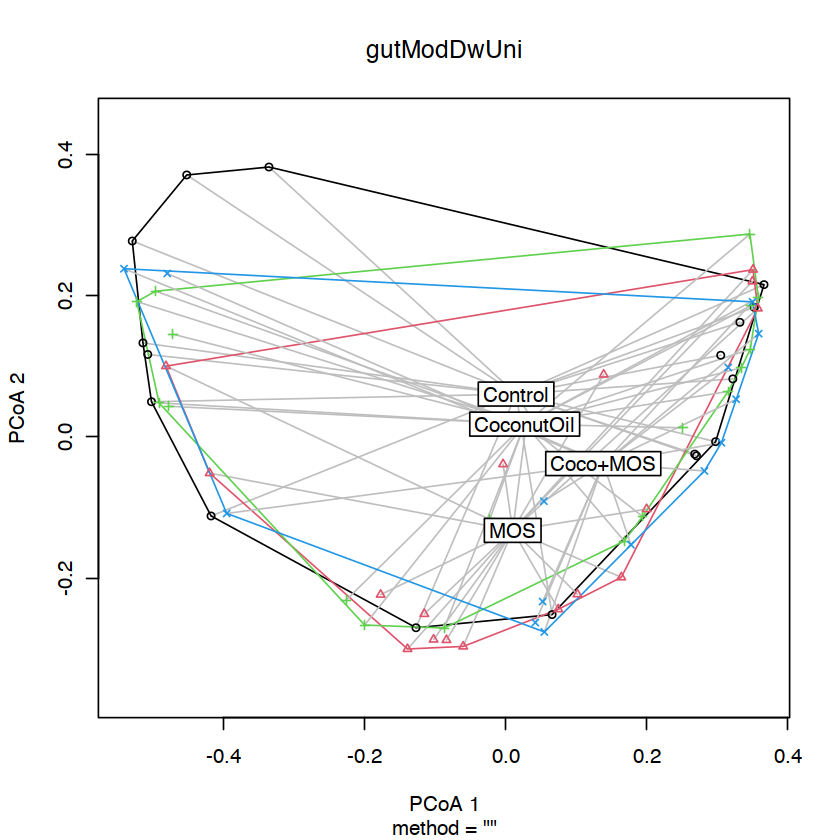

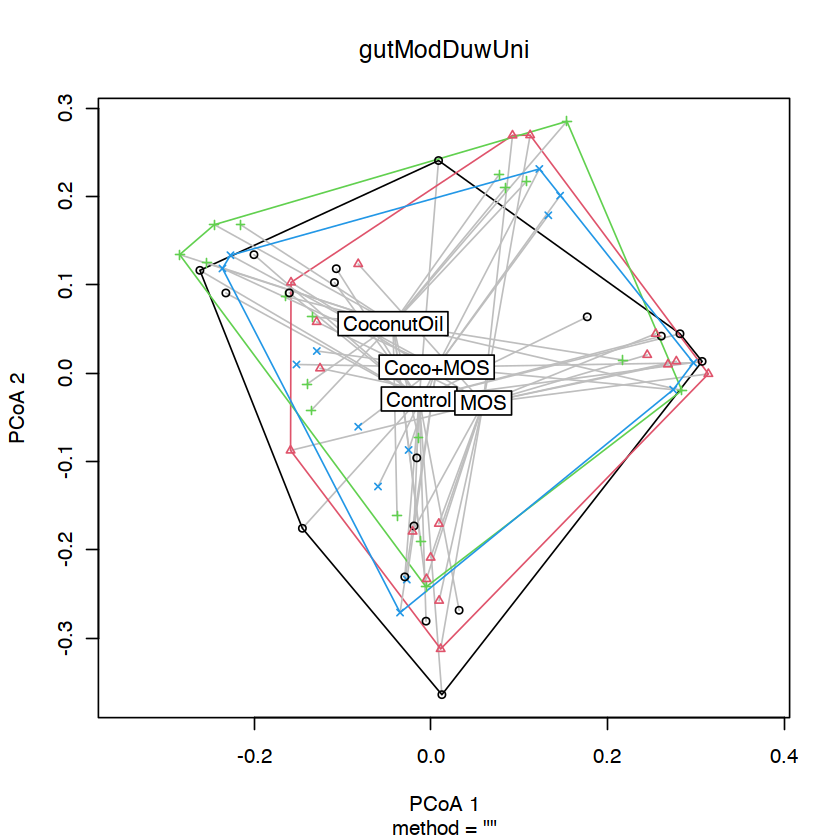

In [41]:
psGutr  <- transform_sample_counts(psGut, function(x) x / sum(x))
gutDict <- as(sample_data(psGutr), "data.frame")
GutDietGroups <- gutDict[["Diet"]]
            
set.seed(123)                                   
psGutrDistWuni <- distance(psGutr, method='wunifrac')
psGutrDistUWuni <- distance(psGutr, method='uunifrac')
                                   
gutModDwUni <- betadisper(psGutrDistWuni, GutDietGroups)
anova(gutModDwUni)
plot(gutModDwUni) 
                                   
gutModDuwUni <- betadisper(psGutrDistUWuni, GutDietGroups)
anova(gutModDuwUni)
plot(gutModDuwUni)                                     

#### Test gut for dietary effects - PERMANOVA

In [42]:
set.seed(123)
perm <- how(nperm = 999)
adonis2(psGutrDistWuni ~ Diet + Diet/Tank, data=gutDict, permutations = perm) # Tank effects were first included in the model and only removed when non-significant                             
adonis2(psGutrDistUWuni ~ Diet + Diet/Tank, data=gutDict, permutations = perm)   

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3,0.7263413,0.04423581,0.9791296,0.424
Diet:Tank,20,4.8133392,0.29314313,0.9732786,0.577
Residual,44,10.8800773,0.66262106,NA,NA
Total,67,16.4197578,1.00000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3,0.8070155,0.04805084,1.081216,0.268
Diet:Tank,20,5.0408714,0.30014056,1.013042,0.403
Residual,44,10.9471489,0.65180861,NA,NA
Total,67,16.7950359,1.00000000,NA,NA


#### Test betadispersion of diet within gill tissue

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.001750369,0.0005834565,0.2301556,0.8750675
Residuals,65,0.164778408,0.0025350524,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.005559366,0.001853122,0.6746048,0.5707188
Residuals,65,0.178553327,0.002746974,NA,NA


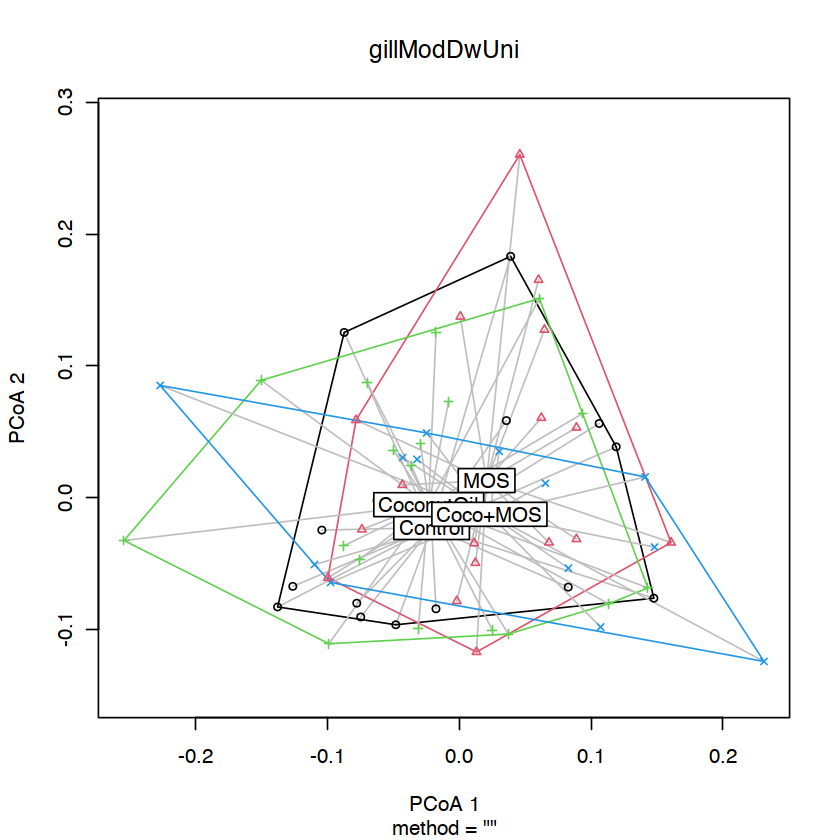

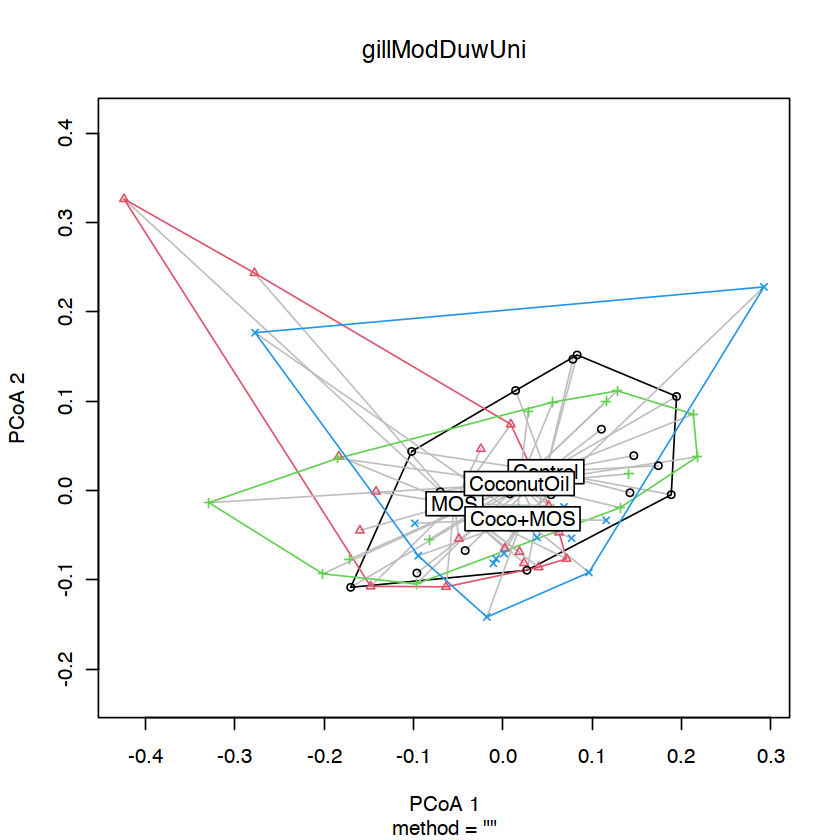

In [43]:
psGillr  <- transform_sample_counts(psGill, function(x) x / sum(x))
gillDict <- as(sample_data(psGillr), "data.frame")
GillDietGroups <- gillDict[["Diet"]]

set.seed(123)
psGillDistWuni <- distance(psGillr, method='wunifrac')
psGillDistUWuni <- distance(psGillr, method='uunifrac')
                                    
gillModDwUni <- betadisper(psGillDistWuni, GillDietGroups)
anova(gillModDwUni)
plot(gillModDwUni)
gillModDuwUni <- betadisper(psGillDistUWuni, GillDietGroups)
anova(gillModDuwUni)
plot(gillModDuwUni)                                       

#### Test gill for dietary effects - PERMANOVA

In [44]:
set.seed(123)
perm <- how(nperm = 999)
#setBlocks(perm) <- with(gillDict, Tank)                                    
adonis2(psGillDistWuni ~ Diet + Diet/Tank, data=gillDict, permutations = perm) # significant tanks effects, but no dietary effects when controlling for tank effect
adonis2(psGillDistUWuni ~ Diet + Diet/Tank, data=gillDict, permutations = perm)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3,0.1601704,0.0496723,1.215350,0.164
Diet:Tank,20,1.0875284,0.3372661,1.237802,0.018
Residual,45,1.9768420,0.6130616,NA,NA
Total,68,3.2245408,1.0000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3,0.6447216,0.04660134,1.094958,0.120
Diet:Tank,20,4.3579712,0.31499997,1.110200,0.005
Residual,45,8.8321377,0.63839869,NA,NA
Total,68,13.8348304,1.00000000,NA,NA


#### Test betadispersion of diet within skin tissue

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.02249094,0.007496980,0.9090826,0.4413407
Residuals,68,0.56077925,0.008246754,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,0.006681918,0.002227306,1.075612,0.3653407
Residuals,68,0.140809858,0.002070733,NA,NA


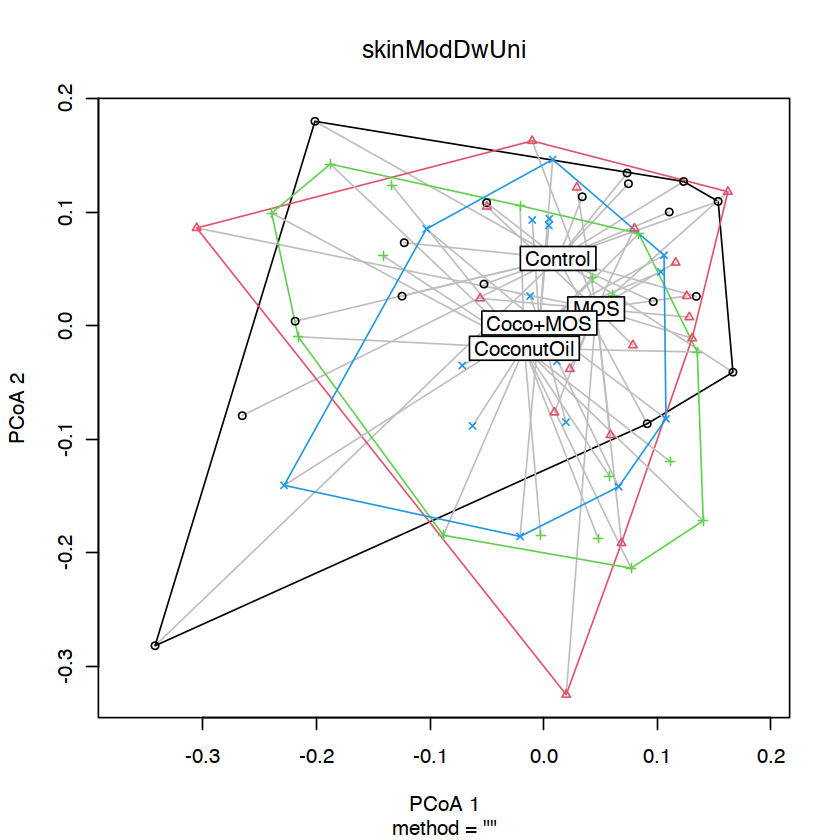

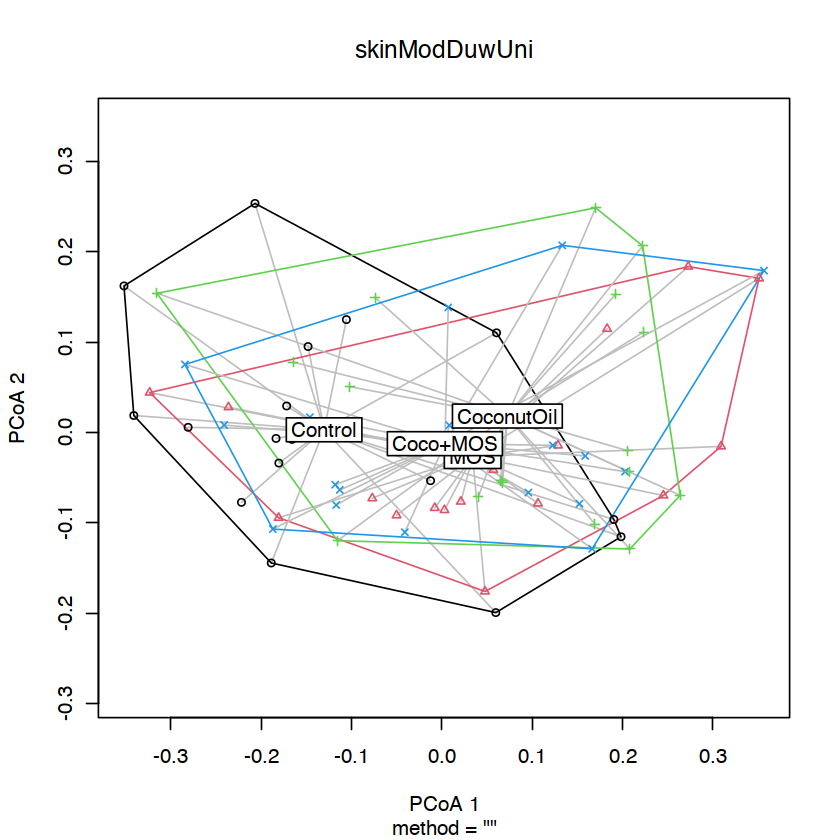

In [45]:
psSkinr  <- transform_sample_counts(psSkin, function(x) x / sum(x))
skinDict <- as(sample_data(psSkinr), "data.frame")
SkinDietGroups <- skinDict[["Diet"]]
                                   
set.seed(123)
psSkinDistWuni <- distance(psSkinr, method='wunifrac')
psSkinDistUWuni <- distance(psSkinr, method='uunifrac')
                                    
skinModDwUni <- betadisper(psSkinDistWuni, SkinDietGroups)
anova(skinModDwUni)
plot(skinModDwUni)
skinModDuwUni <- betadisper(psSkinDistUWuni, SkinDietGroups)
anova(skinModDuwUni)
plot(skinModDuwUni)                                                     

#### Test skin for dietary effects - PERMANOVA

In [46]:
set.seed(123)
perm <- how(nperm = 999)                                   
adonis2(psSkinDistWuni ~ Diet + Diet/Tank, data=skinDict, permutations = perm) # Signficant tank effects but diet effects are still signficant while controling for tank
pairwise.perm.manova(psSkinDistWuni, skinDict$Diet)
adonis2(psSkinDistUWuni ~ Diet + Diet/Tank, data=skinDict, permutations = perm) 
pairwise.perm.manova(psSkinDistUWuni, skinDict$Diet)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3,0.3069193,0.05139355,1.428255,0.039
Diet:Tank,20,2.2267643,0.37287104,1.554343,0.001
Residual,48,3.4382586,0.57573541,NA,NA
Total,71,5.9719422,1.00000000,NA,NA



	Pairwise comparisons using permutation MANOVAs on a distance matrix 

data:  psSkinDistWuni by skinDict$Diet
999 permutations 

           Control MOS  CoconutOil
MOS        0.33    -    -         
CoconutOil 0.33    0.49 -         
Coco+MOS   0.48    0.37 0.59      

P value adjustment method: fdr 

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3,1.041192,0.05858806,1.507208,0.002
Diet:Tank,20,5.677279,0.31946141,1.232747,0.001
Residual,48,11.052936,0.62195053,NA,NA
Total,71,17.771407,1.00000000,NA,NA



	Pairwise comparisons using permutation MANOVAs on a distance matrix 

data:  psSkinDistUWuni by skinDict$Diet
999 permutations 

           Control MOS   CoconutOil
MOS        0.042   -     -         
CoconutOil 0.024   0.425 -         
Coco+MOS   0.064   0.814 0.214     

P value adjustment method: fdr 

### Plot beta diversity

In [47]:
myTheme <- theme(plot.title = element_text(hjust = 0.5, size=15),
                 axis.title = element_text(hjust = 0.5, size=15),
                 axis.text = element_text(size=15))

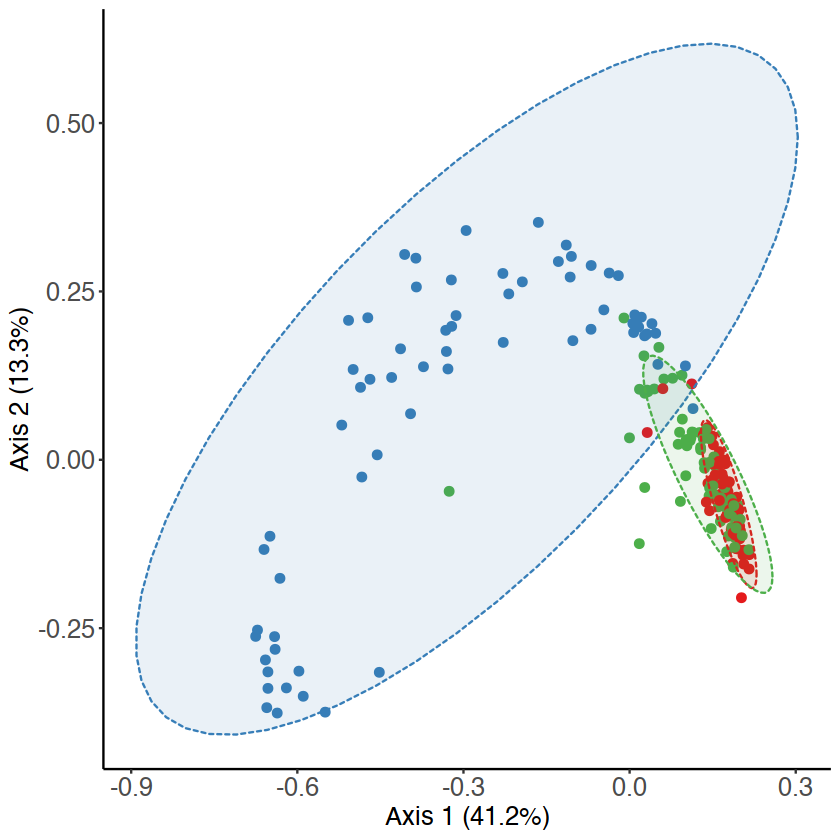

In [48]:
p1wUni = plot_ordination(psFish1rf, allFish.wUn.ord, type="samples", color="Tissue")
p1wUni  <- p1wUni  + geom_point(aes(size=2), alpha=1, size=2
                #) + facet_grid("Tissue"
                              ) + stat_ellipse(geom='polygon', 
                                               linetype = 2, 
                                               alpha=0.1, 
                                               aes(fill=Tissue, group=Tissue, color=Tissue)
                                              ) + theme_classic() + myTheme + xlab('Axis 1 (41.2%)'
                                                                                  ) + ylab('Axis 2 (13.3%)'
                                                                                          ) + theme(legend.position='blank')+ scale_color_brewer(palette = 'Set1', type='div')+ scale_fill_brewer(palette = 'Set1', type='div')
p1wUni

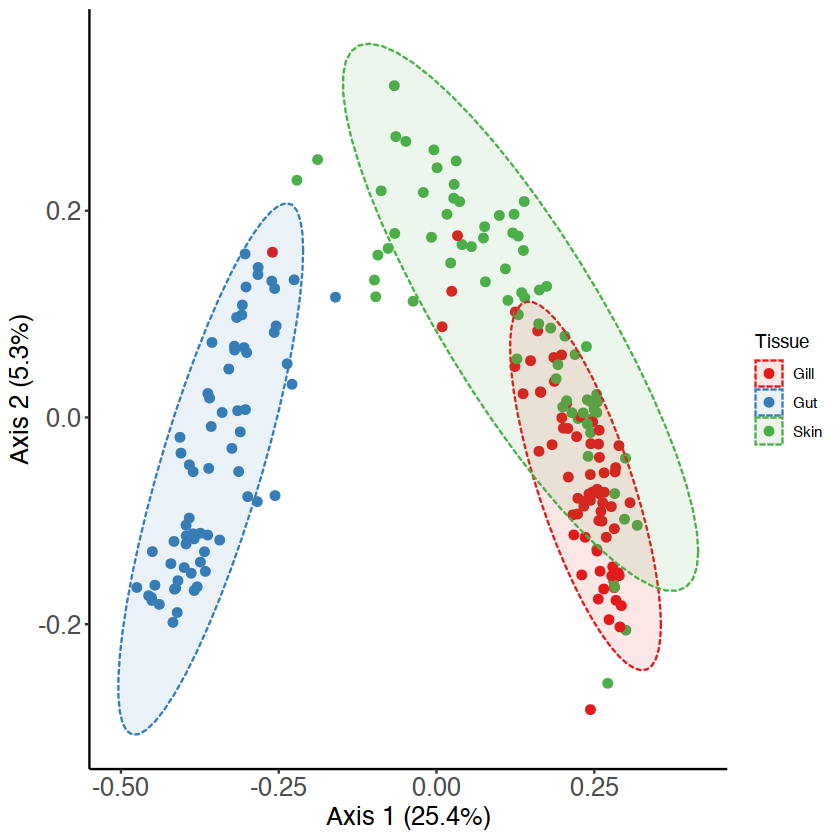

In [49]:
p1uwUni = plot_ordination(psFish1rf, allFish.uwUn.ord, type="samples", color="Tissue")
p1uwUni <- p1uwUni + geom_point(aes(size=2), alpha=1, size=2
                        #) + facet_grid("Tissue"
                                      ) + stat_ellipse(geom='polygon', linetype = 2, alpha=0.1, aes(fill=Tissue, group=Tissue)) + theme_classic() + myTheme + xlab('Axis 1 (25.4%)'
                                                                                                                                                 ) + ylab('Axis 2 (5.3%)'
                                                                                                                                                 ) + scale_color_brewer(palette = 'Set1', type='div') + scale_fill_brewer(palette = 'Set1', type='div')
p1uwUni 

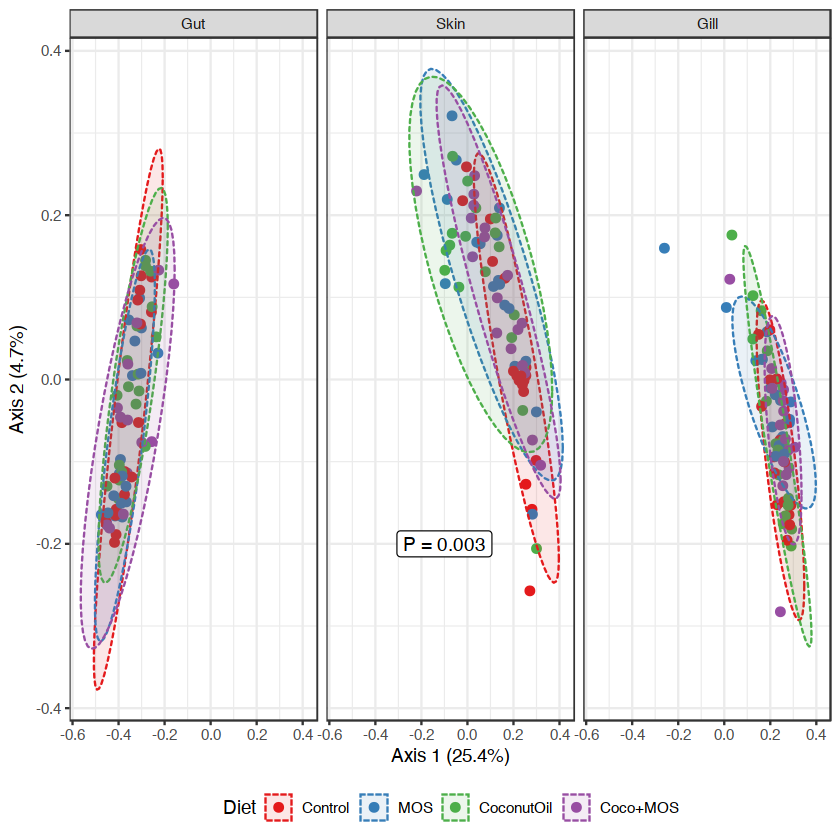

In [50]:
ann_text <- data.frame(Axis.1 = -0.1,Axis.2 = -.2,lab = "Text",
                       Tissue = factor('Skin',levels = c('Gut', 'Skin', 'Gill')),
                       Diet = factor('Control', levels=c('Control', 'MOS', 'CoconutOil', 'CocoMOS')))
#p + geom_text(data = ann_text,label = "Text")


p2uw = plot_ordination(psFish1rf, allFish.uwUn.ord, type="samples", color="Diet")
p2uw$data$Tissue <- factor(p2uw$data$Tissue, levels=c('Gut', 'Skin', 'Gill'))
p2uw <- p2uw + geom_point(aes(size=2), alpha=1, size=2
                ) + facet_wrap("Tissue"
                              ) + stat_ellipse(geom='polygon', linetype = 2, alpha=0.1, aes(group=Diet, fill=Diet)) + theme_bw() + myTheme + xlab('Axis 1 (25.4%)'
                                                                                           ) + ylab('Axis 2 (4.7%)'
                                                                                                ) + theme_bw() + theme(legend.position='bottom') + scale_color_brewer(palette = 'Set1', type='div') + scale_fill_brewer(palette = 'Set1', type='div') + geom_label(data=ann_text,label = 'P = 0.003', color='black', show.legend = FALSE) 
p2uw
#ggsave('Figures/FacetedDiet_uwUniFracMDS.pdf', width=8, height=10, scale=.7)

## Differential abundance testing using DESeq2

In [51]:
ddsFish <- phyloseq_to_deseq2(psFish1f, ~ Tissue * Diet)
ddsFish$Tissue <- factor(ddsFish$Tissue, levels=c('Gut', 'Skin', 'Gill'))
ddsFish$Diet <- factor(ddsFish$Diet, levels=c('Control', 'MOS', 'CoconutOil', 'Coco+MOS'))
ddsFish <- DESeq2::estimateSizeFactors(ddsFish, type='poscount')
ddsFish <- DESeq2::estimateDispersions(ddsFish, fitType = "local")
ddsFish <- DESeq2::DESeq(ddsFish)

Loading required namespace: DESeq2

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but 

In [52]:
DESeq2::resultsNames(ddsFish)

[1] "Intercept"                  "Tissue_Skin_vs_Gut"        
 [3] "Tissue_Gill_vs_Gut"         "Diet_MOS_vs_Control"       
 [5] "Diet_CoconutOil_vs_Control" "Diet_Coco.MOS_vs_Control"  
 [7] "TissueSkin.DietMOS"         "TissueGill.DietMOS"        
 [9] "TissueSkin.DietCoconutOil"  "TissueGill.DietCoconutOil" 
[11] "TissueSkin.DietCoco.MOS"    "TissueGill.DietCoco.MOS"

In [53]:
skinVgut <- DESeq2::lfcShrink(ddsFish, coef = 'Tissue_Skin_vs_Gut', type='apeglm')
sum(skinVgut$padj < 0.05, na.rm=TRUE)
summary(skinVgut)
skinVgutRes <- subset(skinVgut, padj <= 0.05 & abs(log2FoldChange) >= 1)
skinVgutFilt <- skinVgutRes[ order(skinVgutRes$log2FoldChange), ]
nrow(skinVgutFilt)
skinVgutFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 310

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 50

log2 fold change (MAP): Tissue Skin vs Gut 
Wald test p-value: Tissue Skin vs Gut 
DataFrame with 50 rows and 5 columns
       baseMean log2FoldChange     lfcSE      pvalue        padj
      <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ASV27   110.731       -9.75642  4.306931 8.87353e-23 2.58057e-21
ASV2  16166.197       -3.33894  0.647439 9.72615e-09 9.89983e-08
ASV1  24719.689       -3.33639  0.577793 3.16374e-10 3.68793e-09
ASV4   3326.750       -2.59751  1.068139 3.37207e-04 1.96934e-03
ASV52   108.943        3.77242  2.422949 5.79588e-03 2.67286e-02
...         ...            ...       ...         ...         ...
ASV57    79.601        15.0533   4.21203 1.03469e-38 7.02109e-37
ASV24   233.546        15.4478   3.32502 1.81601e-59 2.87535e-57
ASV39   116.704        16.2421   3.72618 1.55389e-80 7.38096e-78
ASV26   181.011        16.5670   3.74775 2.09360e-73 7.45845e-71
ASV17   292.303        16.7571   3.08345 1.34227e-27 5.31316e-26

In [54]:
gillVgut <- DESeq2::lfcShrink(ddsFish, coef = 'Tissue_Gill_vs_Gut', type='apeglm')
sum(gillVgut$padj < 0.05, na.rm=TRUE)
summary(gillVgut)
gillVgutRes <- subset(gillVgut, padj <= 0.05 & abs(log2FoldChange) >= 1)
gillVgutFilt <- gillVgutRes[ order(gillVgutRes$log2FoldChange), ]
nrow(gillVgutFilt)
gillVgutFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 267

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 59

log2 fold change (MAP): Tissue Gill vs Gut 
Wald test p-value: Tissue Gill vs Gut 
DataFrame with 59 rows and 5 columns
         baseMean log2FoldChange     lfcSE      pvalue        padj
        <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ASV1   24719.6885       -3.37031  0.587711 3.65796e-10 4.41745e-09
ASV4    3326.7499       -2.62752  1.096407 3.33465e-04 2.20204e-03
ASV10    769.8512        3.83036  1.585261 3.87544e-04 2.54493e-03
ASV42    120.0689        8.20291  1.696767 1.23924e-08 1.27044e-07
ASV304    22.6142        9.29269  8.602587 2.14815e-12 3.09203e-11
...           ...            ...       ...         ...         ...
ASV20     327.105        15.9409   3.17251 5.41517e-71 1.92915e-68
ASV40     132.967        16.0290   3.84049 2.22926e-60 3.17670e-58
ASV15     413.452        16.4914   2.97194 6.00519e-95 4.27870e-92
ASV30     161.680        16.5540   4.03444 1.29128e-50 1.31434e-48
ASV28     192.508        16.7585   3.89170 1.41206e-61 2.23576e-59

#### Relevel to get skin vs gill comparison

In [55]:
ddsFish$Tissue <- relevel(ddsFish$Tissue, "Gill")
ddsFish_Gill <- DESeq2::DESeq(ddsFish, fitType='local')
DESeq2::resultsNames(ddsFish_Gill)

skinVgill <- DESeq2::lfcShrink(ddsFish_Gill, coef = 'Tissue_Skin_vs_Gill', type='apeglm')
sum(skinVgill$padj < 0.05, na.rm=TRUE)
summary(skinVgill)
skinVgillRes <- subset(skinVgill, padj <= 0.05 & abs(log2FoldChange) >= 1)
skinVgillFilt <- skinVgillRes[ order(skinVgillRes$log2FoldChange), ]
nrow(skinVgillFilt)
skinVgillFilt

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

fitting model and testing

1 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest

  Note: levels of factors in the design contain charac

[1] "Intercept"                  "Tissue_Gut_vs_Gill"        
 [3] "Tissue_Skin_vs_Gill"        "Diet_MOS_vs_Control"       
 [5] "Diet_CoconutOil_vs_Control" "Diet_Coco.MOS_vs_Control"  
 [7] "TissueGut.DietMOS"          "TissueSkin.DietMOS"        
 [9] "TissueGut.DietCoconutOil"   "TissueSkin.DietCoconutOil" 
[11] "TissueGut.DietCoco.MOS"     "TissueSkin.DietCoco.MOS"

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 70

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 1

log2 fold change (MAP): Tissue Skin vs Gill 
Wald test p-value: Tissue Skin vs Gill 
DataFrame with 1 row and 5 columns
       baseMean log2FoldChange     lfcSE      pvalue        padj
      <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ASV46   44.8299       -9.41827   6.09546 2.22821e-15 6.63265e-13

#### Venn diagram of differential tissue ASVs

Loading required package: gplots

Warning message:
“package ‘gplots’ was built under R version 4.0.2”

Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




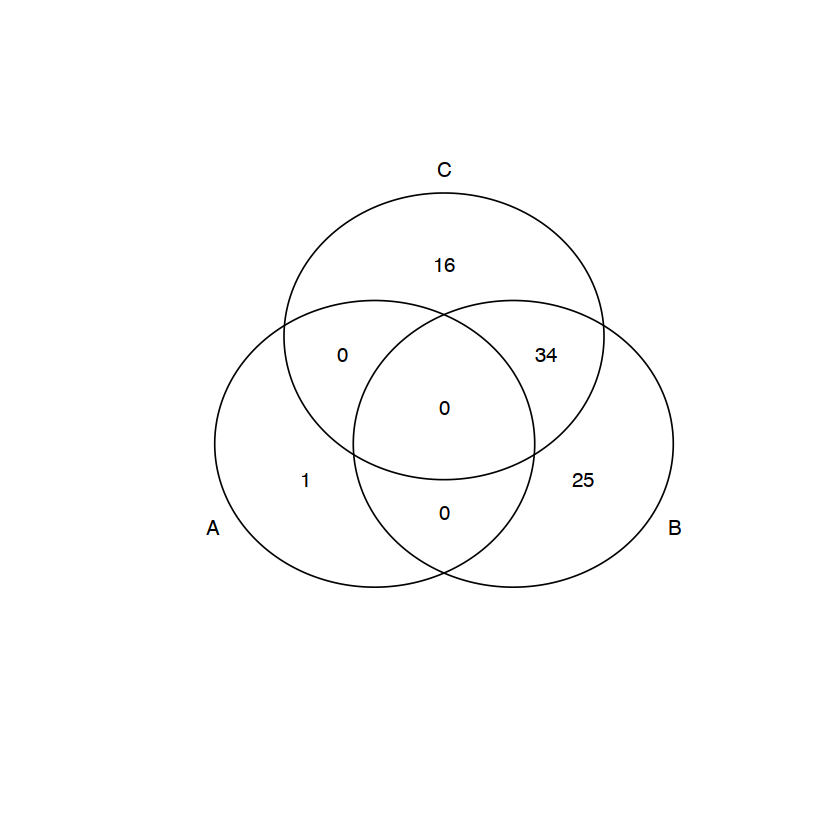

In [56]:
sigskinVgill <- row.names(skinVgillFilt)
siggillVgut <- row.names(gillVgutFilt)
sigskinVgut <- row.names(skinVgutFilt)

require(gplots)
venn(list(sigskinVgill,
          siggillVgut,
          sigskinVgut))

In [57]:
library(VennDiagram)
tiff('Figures/Manuscript/Tissue_DAMs.tiff')
IHN_DTGs <- draw.triple.venn(area1 = 1, 
                             area2 = 58,
                             area3= 44,
                             n12 = 0,
                             n23 = 30,
                             n13 = 0,
                             n123 = 0,
                             category = c('Skin vs. Gill', 'Gill vs. Gut', 'Skin vs. Gut'),
                             fill = c('seagreen',"turquoise","sienna"),
                             #alpha = rep(0.5, 2),
                             cat.pos = c(0, 0, 0),
                             #cat.dist = rep(-0.03, 3),
                             cex = 1,
                             cat.cex = 1,
                             scaled = F,
                             cat.default.pos='text')
dev.off()

Warning message:
“package ‘VennDiagram’ was built under R version 4.0.2”
Loading required package: grid

Loading required package: futile.logger


Attaching package: ‘VennDiagram’


The following object is masked from ‘package:car’:

    ellipse




pdf 
  2

### Global dietary effects - differential abundance

In [58]:
mosVcont <- DESeq2::lfcShrink(ddsFish, coef = 'Diet_MOS_vs_Control', type='apeglm')
sum(mosVcont$padj < 0.05, na.rm=TRUE)
summary(mosVcont)
mosVcontRes <- subset(mosVcont, padj <= 0.05 & abs(log2FoldChange) >= 1)
mosVcontFilt <- mosVcontRes[ order(mosVcontRes$log2FoldChange), ]
nrow(mosVcontFilt)
mosVcontFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 116

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet MOS vs Control 
Wald test p-value: Diet MOS vs Control 
DataFrame with 0 rows and 5 columns

In [59]:
cocoVcont <- DESeq2::lfcShrink(ddsFish, coef = 'Diet_CoconutOil_vs_Control', type='apeglm')
sum(cocoVcont$padj < 0.05, na.rm=TRUE)
summary(cocoVcont)
cocoVcontRes <- subset(cocoVcont, padj <= 0.05 & abs(log2FoldChange) >= 1)
cocoVcontFilt <- cocoVcontRes[ order(cocoVcontRes$log2FoldChange), ]
nrow(cocoVcontFilt)
cocoVcontFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 106

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet CoconutOil vs Control 
Wald test p-value: Diet CoconutOil vs Control 
DataFrame with 0 rows and 5 columns

In [60]:
cocomosVcont <- DESeq2::lfcShrink(ddsFish, coef = 'Diet_CoconutOil_vs_Control', type='apeglm')
sum(cocomosVcont$padj < 0.05, na.rm=TRUE)
summary(cocomosVcont)
cocomosVcontRes <- subset(cocomosVcont, padj <= 0.05 & abs(log2FoldChange) >= 1)
cocomosVcontFilt <- cocomosVcontRes[ order(cocoVcontRes$log2FoldChange), ]
nrow(cocomosVcontFilt)
cocomosVcontFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 106

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet CoconutOil vs Control 
Wald test p-value: Diet CoconutOil vs Control 
DataFrame with 0 rows and 5 columns

#### Now tissue-specific effects of diet

In [61]:
ddsSkin <- phyloseq_to_deseq2(psSkin, ~ Diet)
ddsSkin$Diet <- factor(ddsSkin$Diet, levels=c('Control', 'MOS', 'CoconutOil', 'Coco+MOS'))
ddsSkin <- DESeq2::estimateSizeFactors(ddsSkin) #, type='poscount'
ddsSkin <- DESeq2::estimateDispersions(ddsSkin) #, fitType = "local"
ddsSkin <- DESeq2::DESeq(ddsSkin)

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [62]:
DESeq2::resultsNames(ddsSkin)

[1] "Intercept"                  "Diet_MOS_vs_Control"       
[3] "Diet_CoconutOil_vs_Control" "Diet_Coco.MOS_vs_Control"

In [63]:
conVmosS <- DESeq2::lfcShrink(ddsSkin, coef = 'Diet_MOS_vs_Control', type='apeglm')
sum(conVmosS$padj < 0.05, na.rm=TRUE)
summary(conVmosS)
conVmosSRes <- subset(conVmosS, padj < 0.05 & abs(log2FoldChange) >= 1)
conVmosSFilt <- conVmosSRes[ order(conVmosSRes$log2FoldChange), ]
nrow(conVmosSFilt)
conVmosSFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 50

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet MOS vs Control 
Wald test p-value: Diet MOS vs Control 
DataFrame with 0 rows and 5 columns

In [64]:
conVcocoS <- DESeq2::lfcShrink(ddsSkin, coef ='Diet_CoconutOil_vs_Control', type='apeglm')
sum(conVcocoS$padj < 0.05, na.rm=TRUE)
summary(conVcocoS)
conVcocoSRes <- subset(conVcocoS, padj < 0.05 & abs(log2FoldChange) >= 1)
conVcocoSFilt <- conVcocoSRes[ order(conVcocoSRes$log2FoldChange), ]
nrow(conVcocoSFilt)
conVcocoSFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 62

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet CoconutOil vs Control 
Wald test p-value: Diet CoconutOil vs Control 
DataFrame with 0 rows and 5 columns

In [65]:
conVcocomosS <- DESeq2::lfcShrink(ddsSkin, coef ='Diet_Coco.MOS_vs_Control', type='apeglm')
sum(conVcocomosS$padj < 0.05, na.rm=TRUE)
summary(conVcocomosS)
conVcocomosSRes <- subset(conVcocomosS, padj < 0.05 & abs(log2FoldChange) >= 1)
conVcocomosSFilt <- conVcocomosSRes[ order(conVcocomosSRes$log2FoldChange), ]
nrow(conVcocomosSFilt)
conVcocomosSFilt

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 39

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet Coco.MOS vs Control 
Wald test p-value: Diet Coco.MOS vs Control 
DataFrame with 0 rows and 5 columns

In [66]:
ddsGill <- phyloseq_to_deseq2(psGill, ~ Diet)
ddsGill$Diet <- factor(ddsGill$Diet, levels=c('Control', 'MOS', 'CoconutOil', 'Coco+MOS'))
ddsGill <- DESeq2::estimateSizeFactors(ddsGill) #, type='poscount'
ddsGill <- DESeq2::estimateDispersions(ddsGill) #, fitType = "local"
ddsGill <- DESeq2::DESeq(ddsGill)

DESeq2::resultsNames(ddsGill)

conVmosGi <- DESeq2::lfcShrink(ddsGill, coef = 'Diet_MOS_vs_Control', type='apeglm')
sum(conVmosGi$padj < 0.05, na.rm=TRUE)
summary(conVmosGi)
conVmosGiRes <- subset(conVmosGi, padj < 0.05 & abs(log2FoldChange) >= 1)
conVmosGiFilt <- conVmosGiRes[ order(conVmosGiRes$log2FoldChange), ]
nrow(conVmosGiFilt)
conVmosGiFilt

conVcocoGi <- DESeq2::lfcShrink(ddsGill, coef ='Diet_CoconutOil_vs_Control', type='apeglm')
sum(conVcocoGi$padj < 0.05, na.rm=TRUE)
summary(conVcocoGi)
conVcocoGiRes <- subset(conVcocoGi, padj < 0.05 & abs(log2FoldChange) >= 1)
conVcocoGiFilt <- conVcocoGiRes[ order(conVcocoGiRes$log2FoldChange), ]
nrow(conVcocoGiFilt)
conVcocoGiFilt

conVcocomosGi <- DESeq2::lfcShrink(ddsGill, coef ='Diet_Coco.MOS_vs_Control', type='apeglm')
sum(conVcocomosGi$padj < 0.05, na.rm=TRUE)
summary(conVcocomosGi)
conVcocomosGiRes <- subset(conVcocomosGi, padj < 0.05 & abs(log2FoldChange) >= 1)
conVcocomosGiFilt <- conVcocomosGiRes[ order(conVcocomosGiRes$log2FoldChange), ]
nrow(conVcocomosGiFilt)
conVcocomosGiFilt

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



[1] "Intercept"                  "Diet_MOS_vs_Control"       
[3] "Diet_CoconutOil_vs_Control" "Diet_Coco.MOS_vs_Control"

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 50

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 1

log2 fold change (MAP): Diet MOS vs Control 
Wald test p-value: Diet MOS vs Control 
DataFrame with 1 row and 5 columns
        baseMean log2FoldChange     lfcSE      pvalue        padj
       <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ASV148   21.0533        17.4735   6.88644 5.65876e-10 1.08422e-07

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 34

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet CoconutOil vs Control 
Wald test p-value: Diet CoconutOil vs Control 
DataFrame with 0 rows and 5 columns

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 52

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet Coco.MOS vs Control 
Wald test p-value: Diet Coco.MOS vs Control 
DataFrame with 0 rows and 5 columns

In [67]:
ddsGut <- phyloseq_to_deseq2(psGut, ~ Diet)
ddsGut$Diet <- factor(ddsGut$Diet, levels=c('Control', 'MOS', 'CoconutOil', 'Coco+MOS'))
ddsGut <- DESeq2::estimateSizeFactors(ddsGut) #, type='poscount'
ddsGut <- DESeq2::estimateDispersions(ddsGut) #, fitType = "local"
ddsGut <- DESeq2::DESeq(ddsGut)

DESeq2::resultsNames(ddsGut)

conVmosG <- DESeq2::lfcShrink(ddsGut, coef = 'Diet_MOS_vs_Control', type='apeglm')
sum(conVmosG$padj < 0.05, na.rm=TRUE)
summary(conVmosG)
conVmosGRes <- subset(conVmosG, padj < 0.05 & abs(log2FoldChange) >= 1)
conVmosGFilt <- conVmosGRes[ order(conVmosGRes$log2FoldChange), ]
nrow(conVmosGFilt)
conVmosGFilt

conVcocoG <- DESeq2::lfcShrink(ddsGut, coef ='Diet_CoconutOil_vs_Control', type='apeglm')
sum(conVcocoG$padj < 0.05, na.rm=TRUE)
summary(conVcocoG)
conVcocoGRes <- subset(conVcocoG, padj < 0.05 & abs(log2FoldChange) >= 1)
conVcocoGFilt <- conVcocoGRes[ order(conVcocoGRes$log2FoldChange), ]
nrow(conVcocoGFilt)
conVcocoGFilt

conVcocomosG <- DESeq2::lfcShrink(ddsGut, coef ='Diet_Coco.MOS_vs_Control', type='apeglm')
sum(conVcocomosG$padj < 0.05, na.rm=TRUE)
summary(conVcocomosG)
conVcocomosGRes <- subset(conVcocomosG, padj < 0.05 & abs(log2FoldChange) >= 1)
conVcocomosGFilt <- conVcocomosGRes[ order(conVcocomosGRes$log2FoldChange), ]
nrow(conVcocomosGFilt)
conVcocomosGFilt

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



[1] "Intercept"                  "Diet_MOS_vs_Control"       
[3] "Diet_CoconutOil_vs_Control" "Diet_Coco.MOS_vs_Control"

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 10

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet MOS vs Control 
Wald test p-value: Diet MOS vs Control 
DataFrame with 0 rows and 5 columns

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 14

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet CoconutOil vs Control 
Wald test p-value: Diet CoconutOil vs Control 
DataFrame with 0 rows and 5 columns

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] 17

[1] "DESeqResults object of length 5 with 2 metadata columns"

[1] 0

log2 fold change (MAP): Diet Coco.MOS vs Control 
Wald test p-value: Diet Coco.MOS vs Control 
DataFrame with 0 rows and 5 columns

### Plot Differential Abundance

##### Build phylum level color palette to match other plots (i.e. networks)

Loading required package: microbiomeutilities

Loading required package: microbiome


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2020 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:vegan’:

    diversity


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


Warning message:
“replacing previous import ‘ggplot2::alpha’ by ‘microbiome::alpha’ when loading ‘microbiomeutilities’”
Registered S3 methods overwritten by 'ggtern':
  method           from   
  grid.draw.ggplot ggplot2
  plot.ggplot      ggplot2
  print.ggplot     ggplot2



[1] 111


      Gill v. Gut Gill: CONT v. MOS      Skin v. Gill       Skin v. Gut 
               59                 1                 1                50 

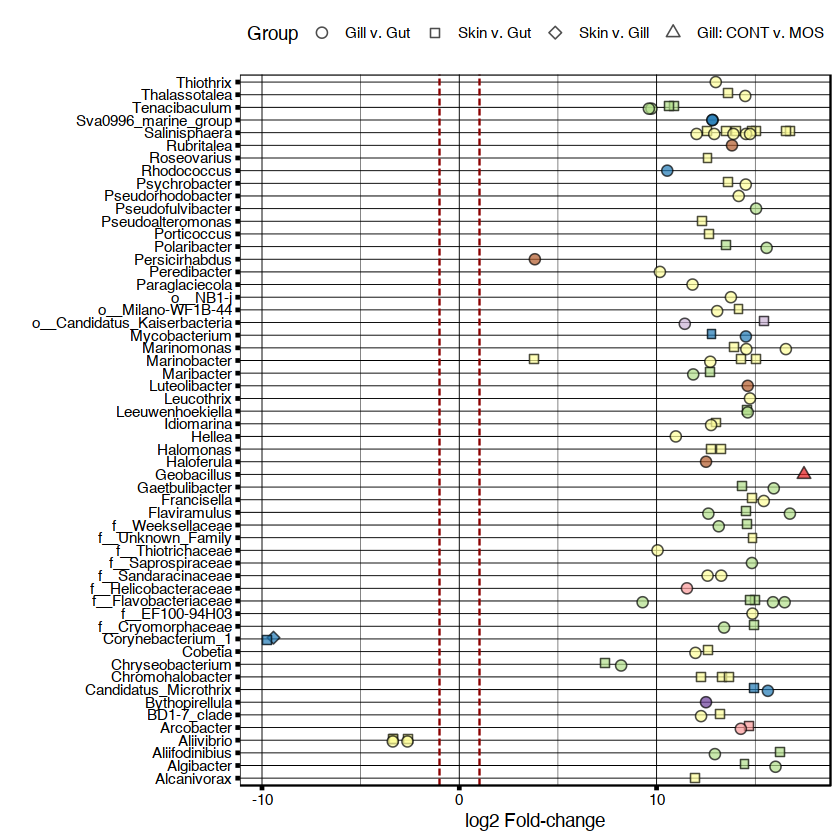

In [68]:
require('microbiomeutilities')
psFish1fbh <- format_to_besthit(psFish1f)
taxa_names(psFish1fbh) <- taxa_names(psFish1f)

sigtabSGi = subset(skinVgill, padj < 0.05)
sigtabSGi = cbind(as(sigtabSGi, "data.frame"), as(tax_table(psFish1fbh)[rownames(sigtabSGi), ], "matrix"))
sigtabSGi$Group <- 'Skin v. Gill'
#head(sigtabSGi)

sigtabSG = subset(gillVgut, padj < 0.05)
sigtabSG = cbind(as(sigtabSG, "data.frame"), as(tax_table(psFish1fbh)[rownames(sigtabSG), ], "matrix"))
sigtabSG$Group <- 'Gill v. Gut'
#head(sigtabSG)

sigtabGuGi = subset(skinVgut, padj < 0.05)
sigtabGuGi = cbind(as(sigtabGuGi, "data.frame"), as(tax_table(psFish1fbh)[rownames(sigtabGuGi), ], "matrix"))
sigtabGuGi$Group <- 'Skin v. Gut'
#head(sigtabGuGi)

sigtabGillConMOS = subset(conVmosGi, padj < 0.05)
sigtabGillConMOS = cbind(as(sigtabGillConMOS, "data.frame"), as(tax_table(psGill)[rownames(sigtabGillConMOS), ], "matrix"))
sigtabGillConMOS$Group <- 'Gill: CONT v. MOS'
#head(sigtabGillConMOS)

sigTabTissue <- dplyr::bind_rows(sigtabSGi, sigtabGuGi, sigtabSG, sigtabGillConMOS)
sigTabTissue <- sigTabTissue %>% filter(abs(log2FoldChange) >= 1 & padj <= 0.05)
nrow(sigTabTissue) # how many total DA microbes
table(sigTabTissue$Group) # how many DA per group

sigTabTissue$Group <- factor(sigTabTissue$Group, levels=c('Gill v. Gut',
                                                          'Skin v. Gut',
                                                          'Skin v. Gill',
                                                          'Gill: CONT v. MOS'))

my_colors <- RColorBrewer::brewer.pal(12, "Paired")
PhylumPalette <- scale_fill_manual(values = c('Acidobacteria' = my_colors[1],
                                                'Actinobacteria' = my_colors[2],
                                                 'Bacteroidetes' = my_colors[3], 
                                                 'Chloroflexi' = my_colors[4],
                                                 'Epsilonbacteraeota' = my_colors[5],
                                                 'Firmicutes' = my_colors[6],
                                                 'Gemmatimonadetes' = my_colors[7],
                                                 'Nitrospirae' = my_colors[8], 
                                                 'Patescibacteria' = my_colors[9],
                                                 'Planctomycetes' = my_colors[10],
                                                 'Proteobacteria' = my_colors[11],
                                                 'Verrucomicrobia' = my_colors[12]))

x = tapply(abs(sigTabTissue$log2FoldChange), sigTabTissue$Phylum, function(x) max(x))
x = sort(x, TRUE)
sigTabTissue$Phylum = factor(as.character(sigTabTissue$Phylum), levels=names(x))
# Genus order
x = tapply(abs(sigTabTissue$log2FoldChange), sigTabTissue$Genus, function(x) max(x))
#x = sort(x, TRUE)
sigTabTissue$Genus = factor(as.character(sigTabTissue$Genus), levels=names(x))
lfcTissue <-ggplot(sigTabTissue, 
                   aes(x=log2FoldChange,
                       y=Genus,
                       fill=Phylum)
                  ) + geom_point(size=2.5,
                                 alpha=.7,
                                 aes(shape=Group),
                                 color='black',
                                 position = position_dodge(width=0.4)) + geom_vline(xintercept=1, linetype="longdash", color = "red4", size=0.5
                                                               ) + geom_vline(xintercept=-1, linetype="longdash", color = "red4", size=0.5
                                                               ) + xlab('log2 Fold-change'
                                                                       ) + ylab(''
                                                                               ) + scale_shape_manual(values = c(21,22,23,24)) + PhylumPalette + theme_linedraw(base_line_size = 2) + guides(fill='none') + theme(legend.position='top')
                                                                                                                         
lfcTissue
saveRDS(lfcTissue, 'Figures/Manuscript/DA_LFC_Final.RDS')           
ggsave(device='png', width=7, height=7, 'Figures/Manuscript/LFC_Tissue.png')      

## Alpha Diversity

Loading required package: ranacapa



rarefying sample T1_F1_Gill
rarefying sample T1_F1_Gut
rarefying sample T1_F1_Skin
rarefying sample T1_F2_Gill
rarefying sample T1_F2_Gut
rarefying sample T1_F2_Skin
rarefying sample T1_F3_Gill
rarefying sample T1_F3_Gut
rarefying sample T1_F3_Skin
rarefying sample T10_F1_Gill
rarefying sample T10_F1_Gut
rarefying sample T10_F1_Skin
rarefying sample T10_F2_Gill
rarefying sample T10_F2_Gut
rarefying sample T10_F2_Skin
rarefying sample T10_F3_Gill
rarefying sample T10_F3_Gut
rarefying sample T10_F3_Skin
rarefying sample T11_F1_Gill
rarefying sample T11_F1_Gut
rarefying sample T11_F1_Skin
rarefying sample T11_F2_Gill
rarefying sample T11_F2_Gut
rarefying sample T11_F2_Skin
rarefying sample T11_F3_Gill
rarefying sample T11_F3_Gut
rarefying sample T11_F3_Skin
rarefying sample T12_F1_Gill
rarefying sample T12_F1_Gut
rarefying sample T12_F1_Skin
rarefying sample T12_F2_Gill
rarefying sample T12_F2_Gut
rarefying sample T12_F2_Skin
rarefying sample T12_F3_Gill
rarefying sample T12_F3_Gut
rarefy

Saving 7 x 7 in image



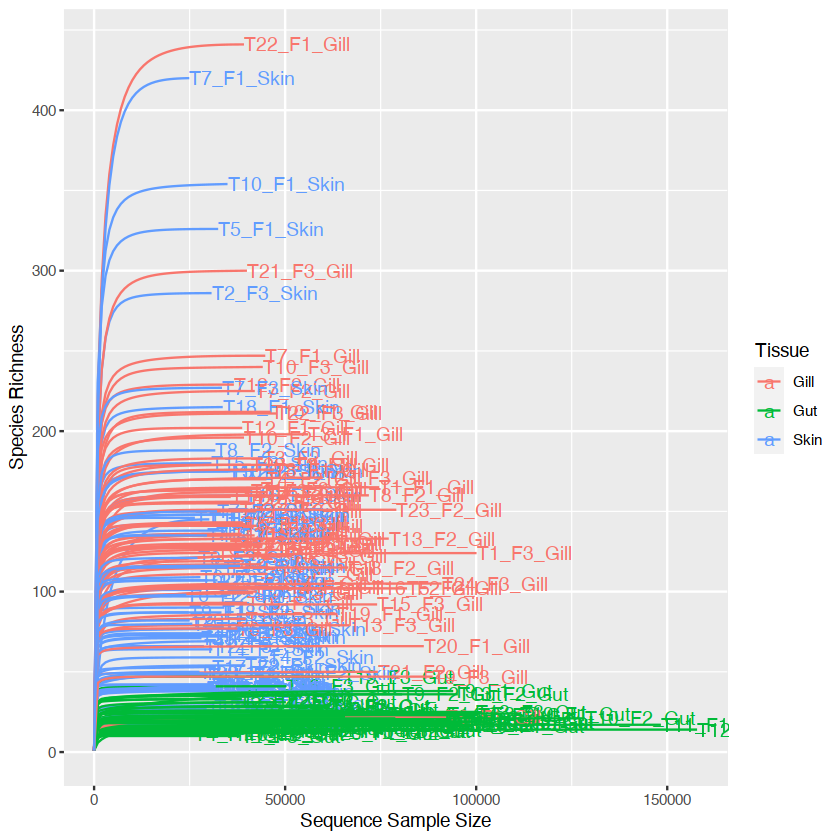

In [69]:
require('ranacapa')
rarePlot <- ggrare(psFish1f, step = 1000, col='Tissue', label = "SampleID", se = F)
rarePlot <- rarePlot + theme_classic()
ggsave('Figures/Manuscript/RichnessRareCurve.png')

#### Full dataset alpha - two-way analysis

In [70]:
AlphaDataFish <- estimate_richness(psFish1f, measures=c("Shannon", "Simpson", "Observed"))

AlphaDataFish$SampleID <- row.names(AlphaDataFish)

metaDataFish <- data.frame(sample_data(psFish1f))
metaDataFish $SampleID <- row.names(metaDataFish)

AlphaDataFish <- merge(metaDataFish, AlphaDataFish, by = "SampleID", all=TRUE)
AlphaDataFish$Tissue <- factor(AlphaDataFish$Tissue, levels= c("Gut", "Skin", "Gill"))
head(AlphaDataFish)

,SampleID,Tank,Fish,Tissue,Diet,Observed,Shannon,Simpson
,<chr>,<chr>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,T1_F1_Gill,T1,F1,Gill,Control,165,4.217393,0.9714539
2,T1_F1_Gut,T1,F1,Gut,Control,22,1.728477,0.7230096
3,T1_F1_Skin,T1,F1,Skin,Control,146,4.485207,0.9822465
4,T1_F2_Gill,T1,F2,Gill,Control,162,3.547739,0.9336441
5,T1_F2_Gut,T1,F2,Gut,Control,35,2.411733,0.8451116
6,T1_F2_Skin,T1,F2,Skin,Control,145,1.096921,0.3652627


### Analyze Observed ASVs (Richness)

#### Detect and remove outliers using Tukeys IQR method, while considering Tissue and Diet groups

In [71]:
Obs <- AlphaDataFish %>% mutate(row_id = row_number()) %>% dplyr::select(Tissue, Diet, Tank, Observed, row_id)
(groupedObs <- Obs %>% group_by(Tissue, Diet) %>% summarise(outlier_row_ids = list(row_id[which(Observed %in% boxplot(Observed ,plot=FALSE)$out)])))
ObsOut <- left_join(Obs, groupedObs)
ObsFishClean <- data.frame(filter(rowwise(ObsOut), ! row_id %in% outlier_row_ids) %>% dplyr::select(-c(outlier_row_ids, row_id)))
nrow(AlphaDataFish) # number of samples before outlier removal
nrow(ObsFishClean) # and number of samples after outlier removal

`summarise()` has grouped output by 'Tissue'. You can override using the `.groups` argument.



Tissue,Diet,outlier_row_ids
<fct>,<fct>,<list>
Gut,Control,5
Gut,MOS,71
Gut,CoconutOil,98
Gut,Coco+MOS,"203, 206"
Skin,Control,"12, 189"
Skin,MOS,171
Skin,CoconutOil,108
Skin,Coco+MOS,
Gill,Control,


Joining, by = c("Tissue", "Diet")



[1] 209

[1] 196

#### Run statistical tests on observed richness - global effects as well as dietary effects within tissues

In [72]:
fishTankObs <- lm(Observed ~ Tissue * Diet + Diet/Tank, data = ObsFishClean)
Anova(fishTankObs, type="II")
fishObs <- lm(Observed ~ Tissue * Diet, data = ObsFishClean) # Drop nested tank effects to from model to enable multiple comparison across tissue
summary(glht(fishObs, linfct = mcp(Tissue = "Tukey"))) # can ignore error 

Note: model has aliased coefficients
      sums of squares computed by model comparison



,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Tissue,475625.88,2,197.407148,2.194117e-44
Diet,28533.46,3,7.895152,5.954620e-05
Tissue:Diet,25484.35,6,3.525736,2.618829e-03
Diet:Tank,49202.89,20,2.042152,7.880793e-03
Residuals,197567.93,164,NA,NA


Warning message in mcp2matrix(model, linfct = linfct):
“covariate interactions found -- default contrast might be inappropriate”



	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lm(formula = Observed ~ Tissue * Diet, data = ObsFishClean)

Linear Hypotheses:
                 Estimate Std. Error t value Pr(>|t|)    
Skin - Gut == 0    110.20      12.76   8.639   <1e-04 ***
Gill - Gut == 0    144.00      12.56  11.464   <1e-04 ***
Gill - Skin == 0    33.80      12.76   2.650   0.0236 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


In [73]:
print('---------------Skin-----------------')
skinObs <- lm(Observed ~  Diet , data = (ObsFishClean %>% filter(Tissue == 'Skin')))
Anova(skinObs, type="II")
summary(glht(skinObs, linfct = mcp(Diet = "Dunnet")))

print('---------------Gill-----------------')
gillObs <- lm(Observed ~  Diet , data = (ObsFishClean %>% filter(Tissue == 'Gill')))
Anova(gillObs, type="II")
summary(glht(gillObs, linfct = mcp(Diet = "Dunnet")))

print('---------------Gut-----------------')
gutObs <- lm(Observed ~  Diet , data = (ObsFishClean %>% filter(Tissue == 'Gut')))
Anova(gutObs, type="II")

[1] "---------------Skin-----------------"


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Diet,38440.17,3,5.741742,0.001526283
Residuals,142823.72,64,NA,NA



	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Dunnett Contrasts


Fit: lm(formula = Observed ~ Diet, data = (ObsFishClean %>% filter(Tissue == 
    "Skin")))

Linear Hypotheses:
                          Estimate Std. Error t value Pr(>|t|)    
MOS - Control == 0          -53.97      16.45  -3.280   0.0047 ** 
CoconutOil - Control == 0   -63.56      16.45  -3.862   <0.001 ***
Coco+MOS - Control == 0     -37.33      16.23  -2.300   0.0635 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


[1] "---------------Gill-----------------"


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Diet,13991.22,3,2.785936,0.0482155
Residuals,102115.80,61,NA,NA



	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Dunnett Contrasts


Fit: lm(formula = Observed ~ Diet, data = (ObsFishClean %>% filter(Tissue == 
    "Gill")))

Linear Hypotheses:
                          Estimate Std. Error t value Pr(>|t|)  
MOS - Control == 0          -40.35      14.03  -2.875   0.0155 *
CoconutOil - Control == 0   -22.82      14.03  -1.626   0.2560  
Coco+MOS - Control == 0     -18.52      14.77  -1.254   0.4596  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


[1] "---------------Gut-----------------"


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Diet,153.2944,3,1.646248,0.188431
Residuals,1831.3088,59,NA,NA


#### Plot observed richness

In [74]:
dat_text <- data.frame(label = c("A", "B", "C", "**", "***", "*"),
                       Tissue = factor(c("Gut","Skin","Gill", 'Skin', 'Skin', 'Gill'),levels = c("Gut","Skin","Gill")),
                       Observed = c(40, 225, 252, 180, 170, 200), 
                       Diet = c(2.5, 2.5, 2.5, 2, 3, 2))
dat_text2 <- data.frame(label = c("A", "B", "C"),
                       Tissue = factor(c("Gut","Skin","Gill"),levels = c("Gut","Skin","Gill")),
                       Observed = c(40, 225, 252), 
                       Diet = 2.5)

Warning message:
“package ‘ggpubr’ was built under R version 4.0.2”

Attaching package: ‘ggpubr’


The following object is masked from ‘package:VennDiagram’:

    rotate




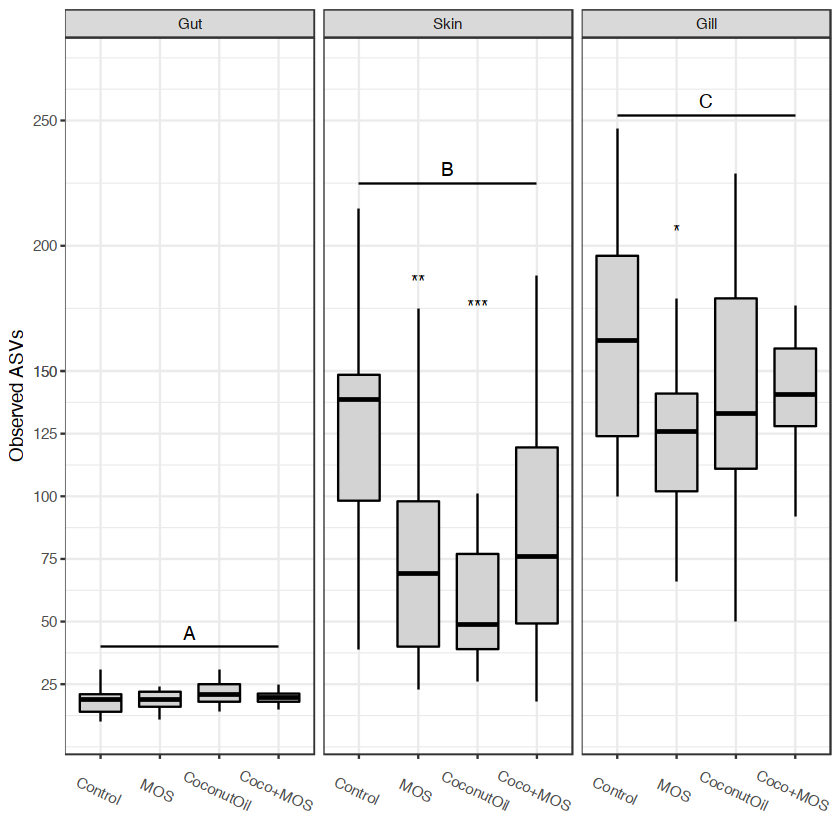

In [75]:
library('ggpubr')
obs2wayTankBox <- ggboxplot(ObsFishClean, x = "Diet", y = "Observed", color = "black", fill='lightgray', facet.by="Tissue", outlier.shape = NA) 
obs2wayTankBox <- obs2wayTankBox + ylab('Observed ASVs'
                                         ) + theme_bw() + scale_y_continuous(breaks=c(seq(25,150,25), seq(150,300,50)),
                                                                            limits=c(10,270)) + xlab(""
                                                                                    ) + theme(axis.text.x=element_text(angle = -25)
                                                                                             ) + geom_text(data = dat_text,
                                                                                                           mapping = aes(x = Diet, y = Observed, label = label),
                                                                                                           vjust = -0.5
                                                                                                          ) + geom_segment(data = dat_text2,
                                                                                                                           mapping = aes(x = 1, 
                                                                                                                                         xend = 4,
                                                                                                                                         y = Observed,
                                                                                                                                         yend = Observed))
obs2wayTankBox
#ggsave('Figures/Manuscript/ObsTwoWay.tiff',  scale=0.9)

### Analyze Shannon Diversity

#### Detect and remove outliers using Tukeys IQR method, while considering Tissue and Diet groups

In [76]:
Shan <- AlphaDataFish %>% mutate(row_id = row_number()) %>% dplyr::select(Tissue, Diet, Tank, Shannon, row_id)
(groupedShan <- Shan %>% group_by(Tissue, Diet) %>% summarise(outlier_row_ids = list(row_id[which(Shannon %in% boxplot(Shannon ,plot=FALSE)$out)])))
ShanOut <- left_join(Shan, groupedShan)
ShanFishClean <- data.frame(filter(rowwise(ShanOut), ! row_id %in% outlier_row_ids) %>% dplyr::select(-c(outlier_row_ids, row_id)))
nrow(AlphaDataFish) # number of samples before outlier removal
nrow(ShanFishClean) # and number of samples after outlier removal

`summarise()` has grouped output by 'Tissue'. You can override using the `.groups` argument.



Tissue,Diet,outlier_row_ids
<fct>,<fct>,<list>
Gut,Control,
Gut,MOS,"71, 173"
Gut,CoconutOil,
Gut,Coco+MOS,
Skin,Control,6
Skin,MOS,114
Skin,CoconutOil,
Skin,Coco+MOS,
Gill,Control,


Joining, by = c("Tissue", "Diet")



[1] 209

[1] 202

#### Run statistical tests on observed richness - global effects as well as dietary effects within tissues

In [77]:
fishTankShan <- lm(Shannon ~ Tissue * Diet + Diet/Tank, data = ShanFishClean)
Anova(fishTankShan, type="II")
fishShan <- lm(Shannon ~ Tissue * Diet, data = ShanFishClean) # Drop nested tank effects to from model to enable multiple comparison across tissue
summary(glht(fishShan, linfct = mcp(Tissue = "Tukey"))) # can ignore error 

Note: model has aliased coefficients
      sums of squares computed by model comparison



,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Tissue,179.275166,2,295.5868348,4.592392e-56
Diet,1.441518,3,1.5845058,1.949650e-01
Tissue:Diet,3.062637,6,1.6832138,1.278424e-01
Diet:Tank,4.220651,20,0.6958961,8.267338e-01
Residuals,51.553003,170,NA,NA


Warning message in mcp2matrix(model, linfct = linfct):
“covariate interactions found -- default contrast might be inappropriate”



	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lm(formula = Shannon ~ Tissue * Diet, data = ShanFishClean)

Linear Hypotheses:
                 Estimate Std. Error t value Pr(>|t|)    
Skin - Gut == 0    2.1975     0.1832  11.993   <1e-04 ***
Gill - Gut == 0    2.3482     0.1832  12.815   <1e-04 ***
Gill - Skin == 0   0.1508     0.1858   0.811    0.697    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


In [78]:
print('---------------Skin-----------------')
skinShan <- lm(Shannon ~  Diet , data = (ShanFishClean %>% filter(Tissue == 'Skin')))
Anova(skinShan, type="II")

print('---------------Gill-----------------')
gillShan <- lm(Shannon ~  Diet , data = (ShanFishClean %>% filter(Tissue == 'Gill')))
Anova(gillShan, type="II")

print('---------------Gut-----------------')
gutShan<- lm(Shannon ~  Diet , data = (ShanFishClean %>% filter(Tissue == 'Gut')))
Anova(gutShan, type="II")

[1] "---------------Skin-----------------"


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Diet,3.460132,3,2.694278,0.0530675
Residuals,28.253545,66,NA,NA


[1] "---------------Gill-----------------"


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Diet,0.3319379,3,1.119264,0.3481859
Residuals,6.1290751,62,NA,NA


[1] "---------------Gut-----------------"


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Diet,0.7366223,3,0.7116779,0.5487102
Residuals,21.3910349,62,NA,NA


#### Plot Shannon diversity

In [79]:
dat_text2 <- data.frame(label = c("A", "B", "B"),
                        Tissue = factor(c("Gut","Skin","Gill"),levels = c("Gut","Skin","Gill")),
                        yVal = c(3.5, 1.8, 2.8), 
                        Diet = 2.5)

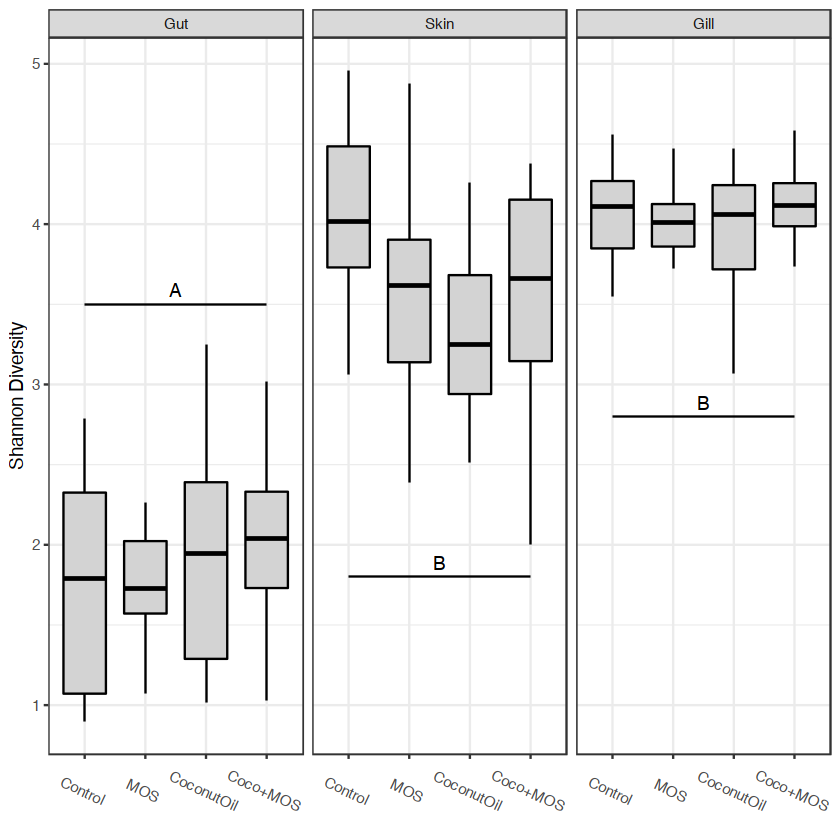

In [80]:
sha2wayTankBox <- ggboxplot(ShanFishClean, x = "Diet", y = "Shannon", color = "black", fill='lightgray', facet.by="Tissue", outlier.shape=NA) 
sha2wayTankBox <- sha2wayTankBox + ylab('Shannon Diversity'
                                     )+ theme_bw() + xlab(""
                                                         ) + theme(axis.text.x=element_text(angle = -25)
                                                                  ) + geom_text(data = dat_text2,
                                                                                mapping = aes(x = Diet, y = yVal, label = label),
                                                                                vjust = -0.5
                                                                               ) + geom_segment(data = dat_text2,
                                                                                                mapping = aes(x = 1, xend=4, y = yVal, yend=yVal))
sha2wayTankBox
#ggsave('Figures/Manuscript/ShannonTwoWay.tiff', scale=0.9)

Saving 8.4 x 8.4 in image



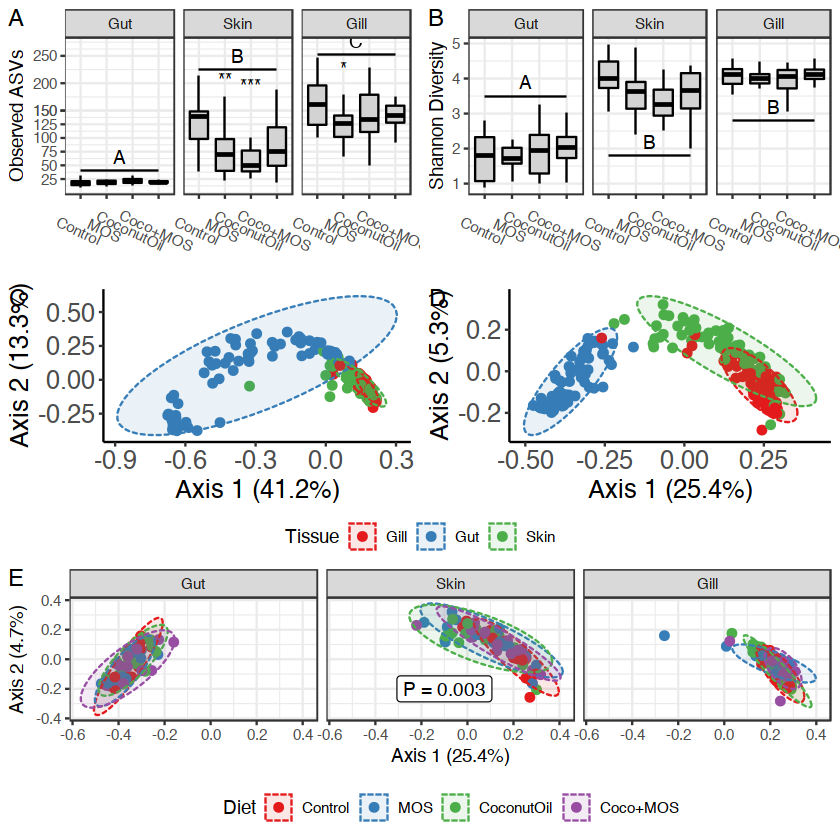

In [81]:
alphaPlots <- ggarrange(obs2wayTankBox, sha2wayTankBox, labels='AUTO')
uniFracPlots <- ggarrange(p1wUni, p1uwUni, common.legend=TRUE, legend='bottom', labels=c('C', 'D'))
ggarrange(alphaPlots, uniFracPlots, p2uw, nrow=3, labels=c('','', 'E'))
ggsave('Figures/Manuscript/MultiPlot.png', scale=1.2, bg = 'white')  

# Plot compositions

### Environmental samples

In [82]:
psDietWater_Merged <- merge_samples(psDietWater, 'Diet')
psDietWater_Merged <- tax_glom(psDietWater_Merged, taxrank = 'Phylum', NArm = FALSE)
psDietWater_Mergedr <- transform_sample_counts(psDietWater_Merged, function(x) x / sum(x))
psDietWaterglom <- tax_glom(psDietWater, taxrank = 'Phylum', NArm = FALSE)                                               
psDietWaterR <- transform_sample_counts(psDietWaterglom , function(x) x / sum(x))    
sample_data(psDietWaterR)$Diet <- factor(sample_data(psDietWaterR)$Diet, levels = c("Water", "Control", "MOS", "CoconutOil", "Coco+MOS"))
levels(sample_data(psDietWaterR)$Diet)                                        

Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”


[1] "Water"      "Control"    "MOS"        "CoconutOil" "Coco+MOS"

In [83]:
length(table(tax_table(psDietWaterR)[,'Phylum']))

[1] 27

In [84]:
library('RColorBrewer')
getPalette = colorRampPalette(brewer.pal(8,'Set1'))
phylumList = unique(tax_table(ps)[,"Phylum"])
phylumPalette = getPalette(length(phylumList))
names(phylumPalette) = phylumList

In [85]:
p = plot_bar(psDietWaterR,
             fill="Phylum") + scale_fill_manual(values=phylumPalette
                                 ) + facet_grid(~Diet, 
                                                scales="free_x") 

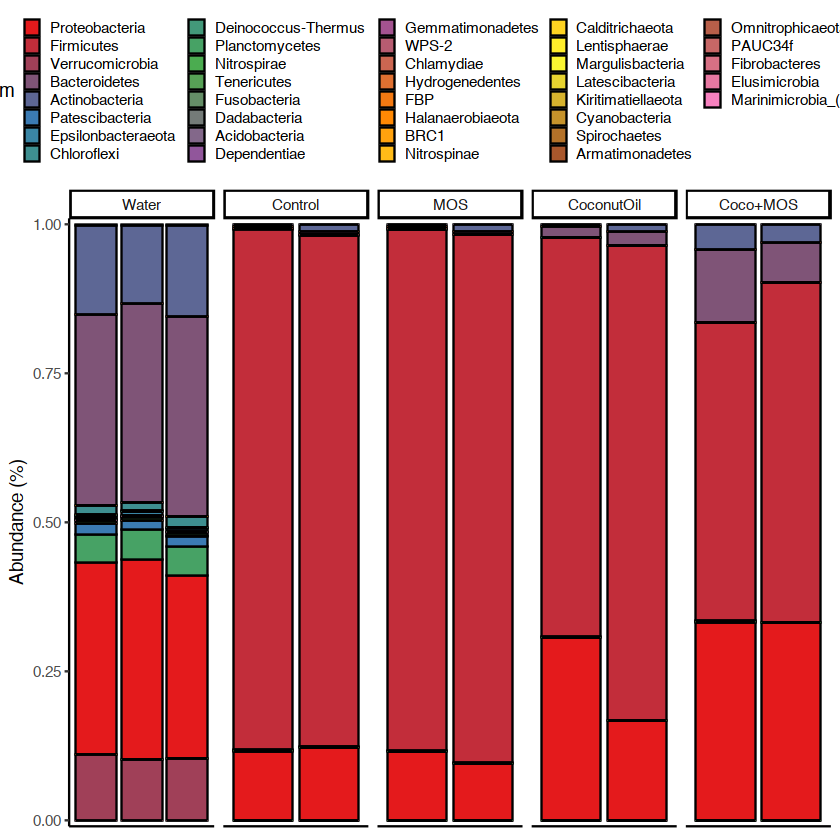

In [86]:
DietWaterP <- p + theme_classic() + theme(axis.text.x = element_blank(),
                                          #strip.text = element_text(face="bold", size=10),
                                          #strip.background = element_rect(fill="white", colour="black",size=1),
                                          legend.position='bottom'
                                          ) + scale_y_continuous(expand=c(0,0.01)#, 
                                                                ) + ylab('Abundance (%)'
                                                                        ) + xlab(""
                                                                                ) + theme(legend.key.size = unit(0.75,'lines'))+ theme(legend.position="top",
                                                                             axis.title.x = element_blank(),
                                                                              axis.text.x = element_blank(),
                                                                              axis.ticks.x = element_blank())
DietWaterP #+ scale_fill_viridis_d()
#ggsave('Figures/Manuscript/EnviroPhyla.tiff', scale = 1.2)

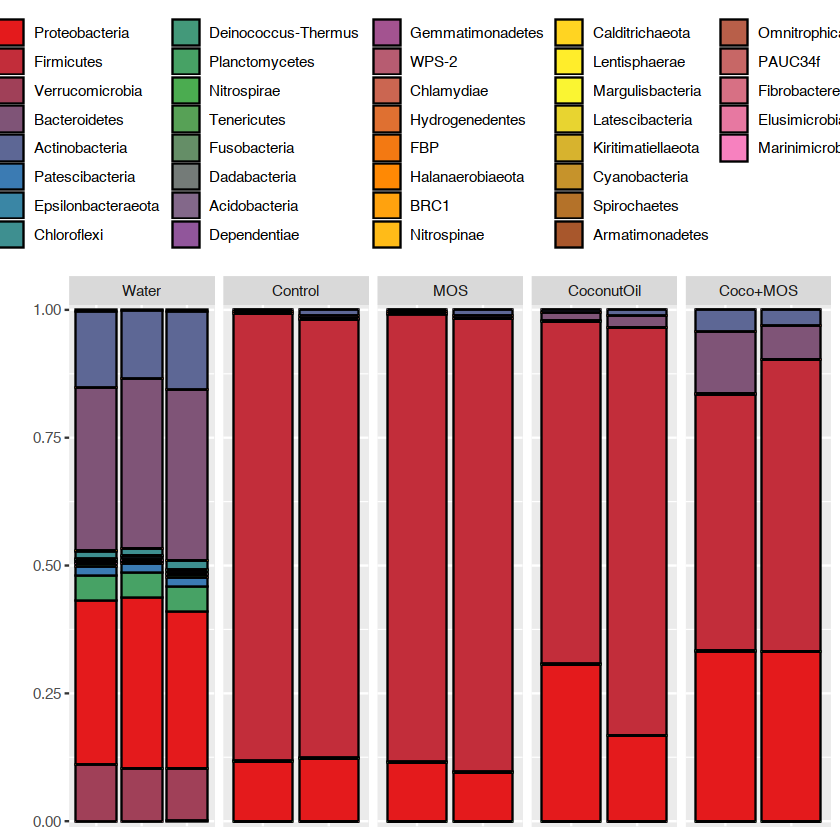

In [87]:
p2 <- p + scale_y_continuous(expand=c(0,0.01)) + xlab("") + ylab("") + theme(legend.position="top",
                                                                             axis.title.x = element_blank(),
                                                                              axis.text.x = element_blank(),
                                                                              axis.ticks.x = element_blank())
p2

## Skin Phyla

In [88]:
psSkin
length(table(tax_table(psSkin)[,'Phylum']))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1604 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 1604 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1604 tips and 1603 internal nodes ]
refseq()      DNAStringSet:      [ 1604 reference sequences ]

[1] 29

In [89]:
skinPlotOrder <- arrange(data.frame(sample_data(psSkin)), Diet)
skinPlotOrder <- skinPlotOrder[,'SampleID']

In [90]:
psSkinP <- tax_glom(psSkin, taxrank = 'Phylum', NArm = FALSE)
psSkinPr  <- transform_sample_counts(psSkinP, function(x) x / sum(x))

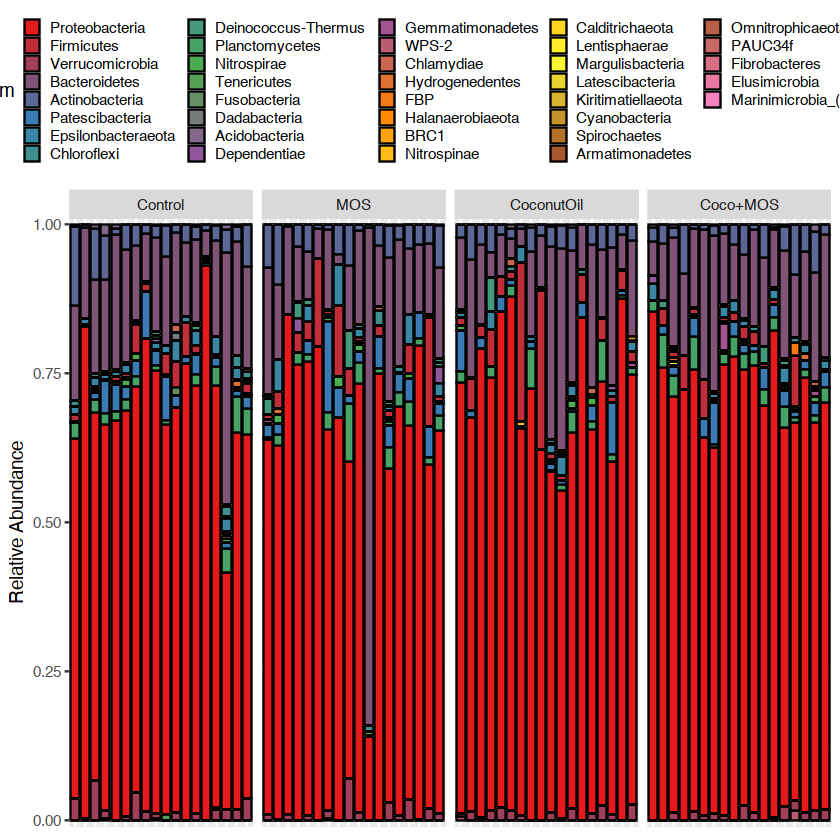

In [91]:
plotSkin = plot_bar(psSkinPr, fill="Phylum") + scale_fill_manual(values=phylumPalette) + theme(legend.key.size = unit(0.75,'lines'))
plotSkin$data$Sample <- factor(plotSkin$data$Sample, levels = skinPlotOrder)
plotSkin <- plotSkin + facet_grid(~Diet, scales="free_x") + scale_y_continuous(expand=c(0,0.01)) + xlab("") + ylab("Relative Abundance") + theme(legend.position="top",
                                                                                                                                                 axis.title.x = element_blank(),
                                                                                                                                                  axis.text.x = element_blank(),
                                                                                                                                                  axis.ticks.x = element_blank())
plotSkin
#ggsave('Figures/Manuscript/SkinPhylaBar.pdf', scale = 1.5)#, width = 18, height = 10)

## Gill Phyla

In [92]:
gillPlotOrder <- arrange(data.frame(sample_data(psGill)), Diet)
gillPlotOrder <- gillPlotOrder[,'SampleID']

In [93]:
psGillP <- tax_glom(psGill, taxrank = 'Phylum', NArm = FALSE)
psGillPr  <- transform_sample_counts(psGillP, function(x) x / sum(x))
length(table(tax_table(psGillPr)[,'Phylum']))

[1] 31

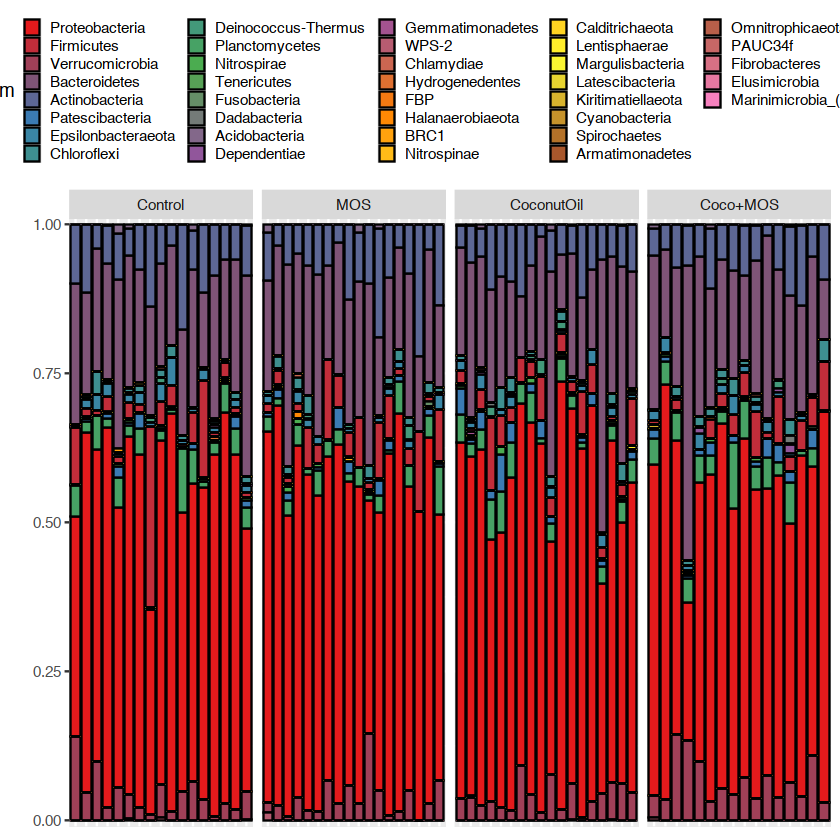

In [94]:
plotGill = plot_bar(psGillPr, fill="Phylum") + scale_fill_manual(values=phylumPalette) + theme(legend.key.size = unit(0.75,'lines'))
plotGill$data$Sample <- factor(plotGill$data$Sample, levels = gillPlotOrder)
plotGill <- plotGill + facet_grid(~Diet, scales="free_x") + scale_y_continuous(expand=c(0,0.01)) + xlab("") + ylab("") + theme(legend.position="top",
                                                                                                                                 axis.title.x = element_blank(),
                                                                                                                                  axis.text.x = element_blank(),
                                                                                                                                  axis.ticks.x = element_blank())
plotGill
#ggsave('Figures/Manuscript/GillPhylaBar.pdf', scale = 1.5)#, width = 18, height = 10)

## Gut Phyla

In [95]:
gutPlotOrder <- arrange(data.frame(sample_data(psGut)), Diet)
gutPlotOrder <- gutPlotOrder[,'SampleID']

In [96]:
psGutP <- tax_glom(psGut, taxrank = 'Phylum', NArm = FALSE)
psGutPr  <- transform_sample_counts(psGutP, function(x) x / sum(x))
length(unique(tax_table(psGillPr)[,'Phylum']))                           

[1] 31

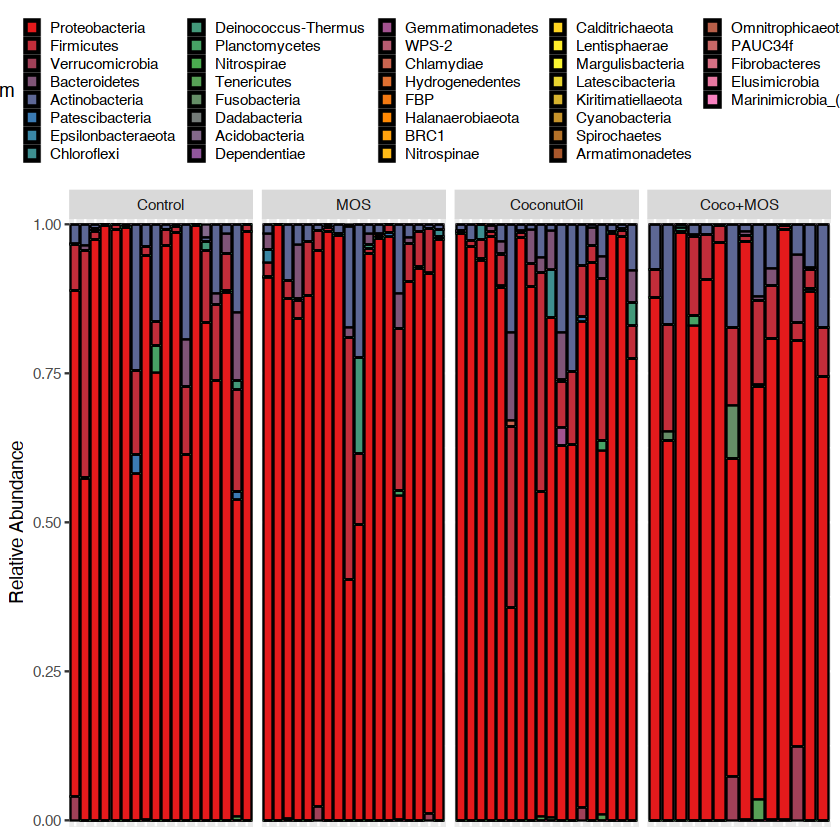

In [97]:
plotGut = plot_bar(psGutPr, fill="Phylum") + scale_fill_manual(values=phylumPalette) + guides(fill = guide_legend(override.aes = list(size=1))) + theme(legend.key.size = unit(0.75,'lines'))
plotGut$data$Sample <- factor(plotGut$data$Sample, levels = gutPlotOrder)
plotGut <- plotGut + facet_grid(~Diet, scales="free_x") + scale_y_continuous(expand=c(0,0.01)) + xlab("") + ylab("Relative Abundance") + theme(legend.position="top",
                                                                                                                                                 axis.title.x = element_blank(),
                                                                                                                                                  axis.text.x = element_blank(),
                                                                                                                                                  axis.ticks.x = element_blank())
plotGut
#ggsave('Figures/Manuscript/GutPhylaBar.pdf', scale = 1.5)#, width = 18, height = 10)

In [98]:
PhyPlot <- ggarrange(plotSkin, plotGill, plotGut, p2, ncol=2, nrow=2, common.legend = TRUE, legend = 'top', labels = 'AUTO', label.x = ) + guides(fill = guide_legend(override.aes = list(size=1)))

Loading required package: cowplot

Warning message:
“package ‘cowplot’ was built under R version 4.0.2”

Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend


Saving 8.26 x 8.26 in image



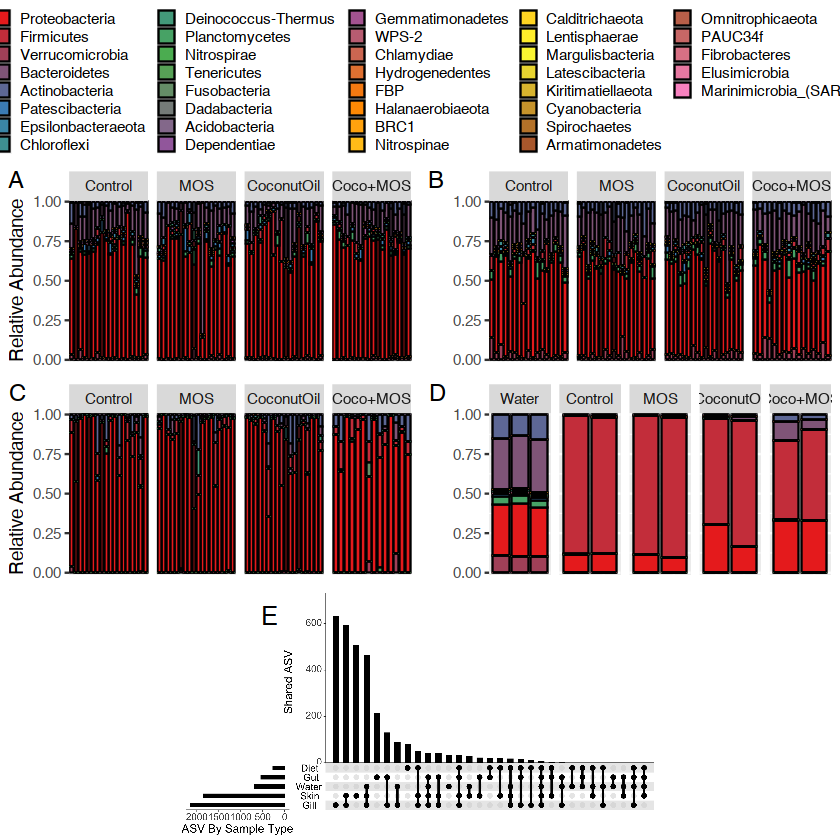

In [99]:
upSetPlot <- png::readPNG('/Users/jakebledsoe/Desktop/NCWMAC\ Projects/Functional\ Feed\ Study/MicroAnalysis/NCWMAC_Micro/Figures/Manuscript/upSetPlot.png')

upSetPlotFig <- ggarrange(rasterGrob(upSetPlot))
#ggarrange(lfcTissue ,upSetPlotFig, ncol=1)
require('cowplot')
ggdraw() + draw_plot(PhyPlot, x=0, y=0.3, height=0.7, width=1) +
  draw_plot(upSetPlotFig, x=0, y=0, height=0.3, width=1) +
  draw_plot_label(label = "E", size = 15,
                  x = 0.3, y = .29)
ggsave('Figures/Manuscript/CompostionPlot.png', scale=1.18, bg='white')   